# Quality Inspection

1. [Introduction](#introduction)  
1.1. [Objectives](#objectives)  
1.2. [Requirements](#requirements)  
1.3. [Dataset](#dataset)  

2. [Data Analysis](#data)  
2.1. [Imports](#imports)  
2.2. [LLoading image paths](#loading_data)  

3. [EDA](#eda)

4. [Feature Engineering](#feature_engineering)  

5. [Models](#models)  
5.1. [Data Pipeline and Model Architecture Configuration](#model_architecture)  
5.2. [Process Images to Data](#process_images)  
5.2. [Optuna Configuration](#optuna)  
5.3. [Test Model with Best Hyperparameter and Weights](#test_model)  
5.4. [Defects](#defects)  

6. [Conclusion](#conclusion)

<a id="introduction"></a>
# 1. Introduction

<a id="objectives"></a>
## 1.1. Objectives

#### 1. Practice Conducting Exploratory Data Analysis (EDA) for Image Dataset
- Conduct EDA to gain insights into the characteristics of the image dataset.
- Analyze image properties, including pixel intensity distributions, shape, and structure of defects in images.
- Utilize visualizations like histograms, edge-detection, and other statistical methods to identify key features of defective and non-defective brake discs.

#### 2. Practice Designing and Implementing Tests to Evaluate Product Quality
- Design tests to assess the quality of images and the model's ability to detect defects in brake discs.
- Implement automated tests that evaluate the model's classification performance, accuracy, and prediction consistency.
- Monitor and log the evaluation metrics for both training and testing to ensure the model does not overfit and performs well on unseen data.

#### 3. Practice Applying Image Processing Techniques for Quality Assessment
- Apply different image processing techniques (e.g., Sobel edge detection, thresholding, etc.) to enhance the quality assessment of brake discs.
- Extract meaningful features from images (e.g., edges, areas of interest) to help the model distinguish defective discs from normal ones.
- Fine-tune the edge-detection and thresholding techniques to improve defect detection accuracy.

#### 4. Practice Iteratively Refining Algorithms Based on Test Results
- Continuously refine the image processing and machine learning algorithms based on test results and performance feedback.
- Adjust hyperparameters and processing steps based on the analysis of model errors, ensuring that the system learns from its mistakes.
- Experiment with different model architectures, training strategies, and feature extraction methods to enhance prediction performance.

#### 5. Practice Integrating Multiple Image Processing Techniques into a Robust Algorithm
- Combine multiple image processing techniques to create a robust algorithm capable of detecting defects in brake discs with high accuracy.
- Implement a pipeline that includes data preprocessing, feature extraction, defect detection, and classification.
- Ensure that the integrated techniques work together seamlessly to improve the overall effectiveness and efficiency of the model.

#### 6. Mark Defected Disc Areas
- Use the trained model to identify and mark defective areas on brake discs.
- Visualize defected regions by overlaying bounding boxes or other markers on the images.
- Evaluate the performance of the defect marking process to ensure that it accurately highlights the defective regions without false positives or missed defects.


<a id="requirements"></a>
## 1.2. Requirements

- Download Data for Quality Inspection:  
  Download 1300 images from the `casting_512x512` directory for quality inspection purposes.  

- Conduct EDA on Images:  
  Perform Exploratory Data Analysis (EDA) on the images to analyze their properties and characteristics. Utilize visualizations and image processing techniques (e.g., edge detection, pixel intensity histograms) to better understand the dataset and its features.

- Create 3 Partition Data Splits:  
  Split the 1300 images into three parts:  
  - 30% of images will be used for understanding the digital images and their respective important features.  
  - 30% of images will be used for validation to select the best-performing approach.  
  - 40% of images will be used exclusively for testing, ensuring that they are only used once during the model evaluation.

- Build an Algorithm Using Digital Image Processing Techniques:  
  Develop an algorithm that uses various image processing techniques (e.g., edge detection, thresholding, etc.) for robust classification of images into defective and proper metal castings. The algorithm should classify the images into two categories based on their condition: defective and non-defective.

- Evaluate the Best Performing Algorithm on the Test Dataset:  
  After training the model, evaluate the best-performing algorithm using the test dataset. Provide a classification report including accuracy, precision, recall, F1-score, and support for both defective and non-defective categories.  

- Evaluate the Processing Time of the Best Performing Algorithm:  
  Measure and evaluate the processing time of the best-performing algorithm. This includes assessing how much time the algorithm takes to make predictions on the test dataset and how long the entire process takes.

- Implement an Additional Feature to Highlight Defective Points:  
  Implement a feature that highlights defective areas in the images by drawing bounding boxes around the detected defects. If the classifier detects any defects, the corresponding defective areas should be clearly marked in the image.

- Suggestions for Improving the Algorithm:  
  Based on the evaluation results, provide suggestions for further enhancing the algorithm. This could involve experimenting with different image processing techniques, model architectures, hyperparameter tuning, or exploring methods to handle false positives and false negatives more effectively.



<a id="dataset"></a>
## 1.3. Dataset

This project focuses on classifying defective and non-defective submersible pump impeller images using a dataset from Kaggle:  
[Real-Life Industrial Dataset of Casting Product](https://www.kaggle.com/datasets/ravirajsinh45/real-life-industrial-dataset-of-casting-product).

#### Dataset Overview
- The dataset consists of grayscale images of submersible pump impellers, captured from the top view.
- The images have dimensions of 512x512 pixels.
- There are a total of 7348 images, with a combination of augmented (300x300 pixels) and non-augmented (512x512 pixels) images.
- The dataset is already split into two folders: train and test.
  - Train Folder:
    - def_front: 3758 images of defective impellers.
    - ok_front: 2875 images of non-defective impellers.
  - Test Folder:
    - def_front: 453 images of defective impellers.
    - ok_front: 262 images of non-defective impellers.

<a id="data"></a>
# 2. Data Analysis

<a id="imports"></a>
## 2.1. Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.color import rgb2gray
import time
from PIL import Image
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.ndimage import laplace
from skimage.measure import regionprops, label
import scipy.stats as stats
from numpy.fft import fft2, fftshift
from skimage.filters import sobel
from skimage import io
from scipy.stats import skew, kurtosis
from skimage.draw import rectangle_perimeter
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torchmetrics
import pytorch_lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from lightning.pytorch.loggers import CSVLogger
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import random
from pytorch_lightning.callbacks import ModelCheckpoint
import optuna
from sklearn.metrics import classification_report

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

<a id="loading_data"></a>
## 2.2. Loading image paths

In [3]:
data_dir = "data"
defect_dir = os.path.join(data_dir, "def_front")
ok_dir = os.path.join(data_dir, "ok_front")

defect_images = [os.path.join(defect_dir, img) for img in os.listdir(defect_dir)]
ok_images = [os.path.join(ok_dir, img) for img in os.listdir(ok_dir)]

<a id="eda"></a>
# 3. EDA

### Check Distribution for Each Class

In [4]:
ids_ok = [
    int(image.replace("data\\ok_front\\cast_ok_0_", "").replace(".jpeg", ""))
    for image in ok_images
]
ids_def = [
    int(image.replace("data\\def_front\\cast_def_0_", "").replace(".jpeg", ""))
    for image in defect_images
]
len(ids_ok), len(ids_def)

(519, 781)

This distribution indicates a slight imbalance, with more defective images than non-defective ones. However, the difference is not significant enough to cause major issues in model training. But still monitor performance metrics carefully to ensure the model does not become biased toward the majority class.

### Display defective and non-defective discs

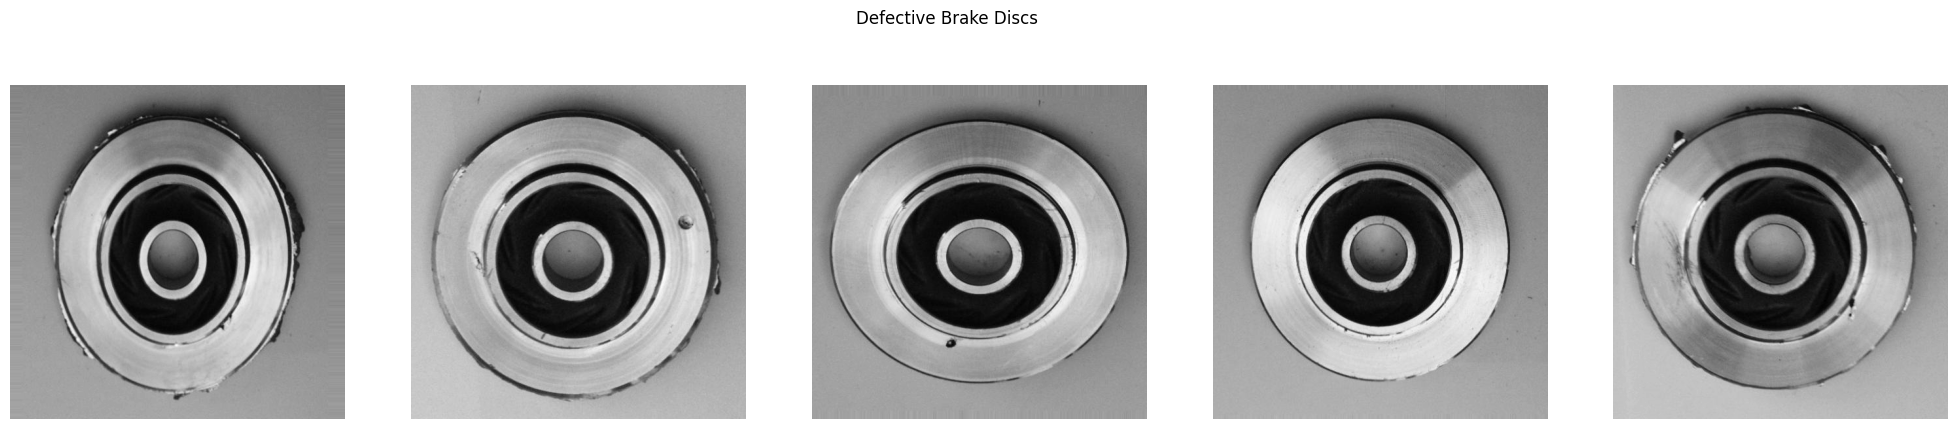

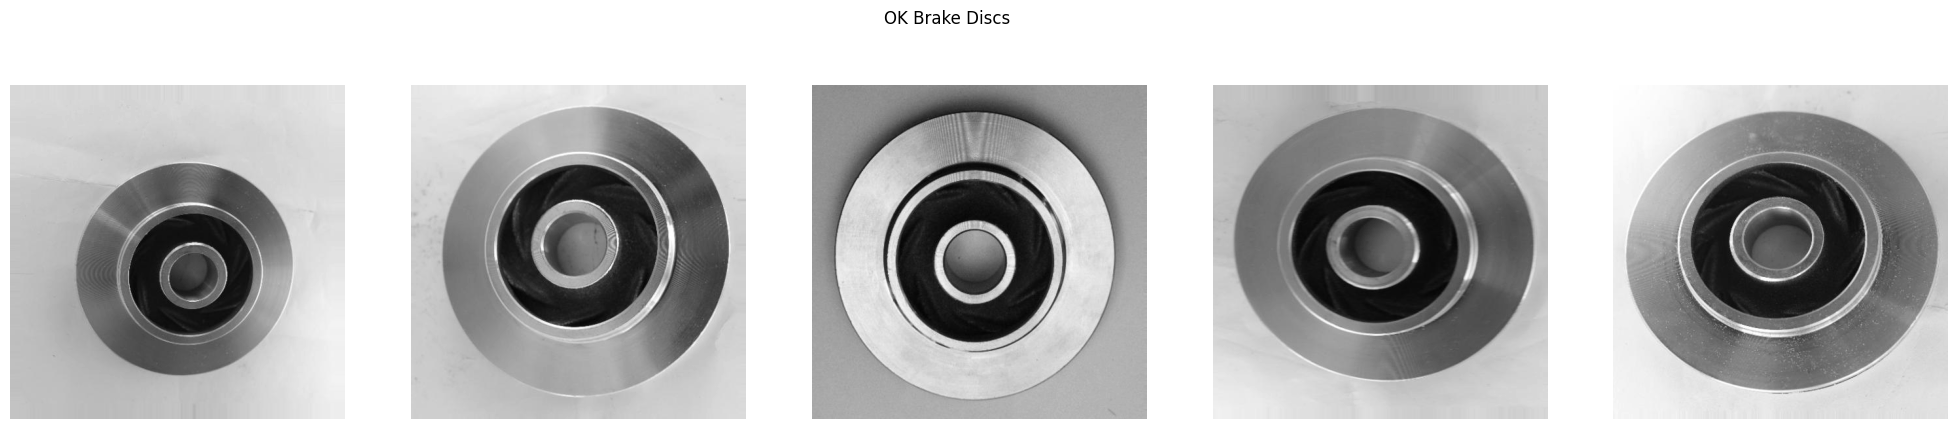

In [5]:
def show_images(image_paths: list, title: str) -> None:
    """
    Display a series of images in a single row, with a title above them.

    Parameters:
    -----------
    image_paths : List[str]
        A list of file paths to the images to be displayed.
    title : str
        The title to be displayed above the images.

    Returns:
    --------
    None
        This function does not return anything, it just displays the images.
    """
    fig, axes = plt.subplots(1, len(image_paths), figsize=(25, 5))
    for i, img_path in enumerate(image_paths):
        img = imread(img_path)
        if len(img.shape) == 3:
            img = rgb2gray(img)
        axes[i].imshow(img, cmap="gray")
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()


show_images(defect_images[:5], "Defective Brake Discs")
show_images(ok_images[:5], "OK Brake Discs")

By plotting multiple images side by side, we can compare defective and non-defective discs to observe patterns that differentiate them and it is not difficult to separate two groups visually.


### Edge Detection to Highlight Defects

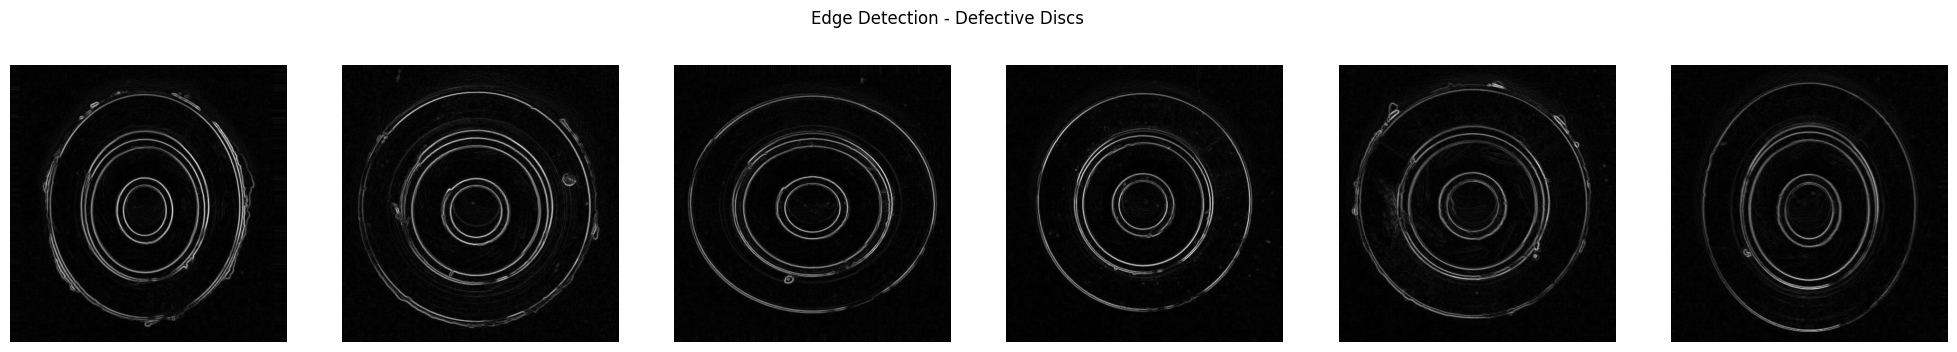

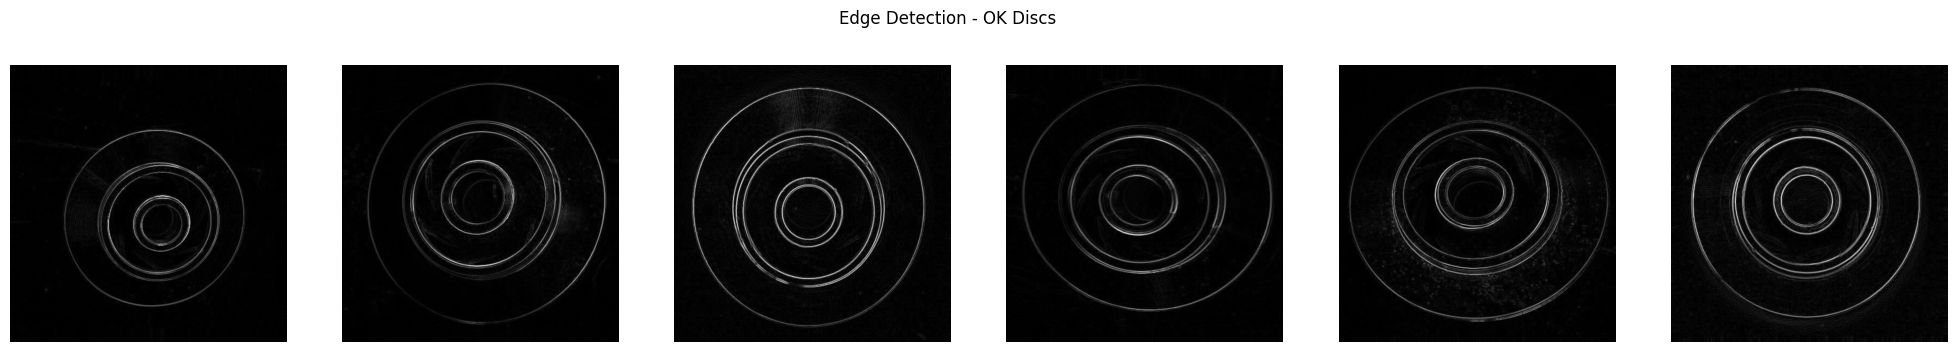

In [6]:
def show_edge_detection(image_paths: list, title: str) -> None:
    """
    Display a series of images with edge detection applied, using the Sobel filter.

    Parameters:
    -----------
    image_paths : List[str]
        A list of file paths to the images to be processed and displayed.
    title : str
        The title to be displayed above the images.

    Returns:
    --------
    None
        This function does not return anything, it just displays the processed images.
    """
    fig, axes = plt.subplots(1, len(image_paths), figsize=(25, 4))
    for i, img_path in enumerate(image_paths):
        img = imread(img_path, as_gray=True)
        edges = sobel(img)
        axes[i].imshow(edges, cmap="gray")
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()


show_edge_detection(defect_images[:6], "Edge Detection - Defective Discs")
show_edge_detection(ok_images[:6], "Edge Detection - OK Discs")

By applying the Sobel filter to detect edges in the images, observe that defective discs exhibit irregular, sharp-edged shapes, whereas OK discs tend to maintain a more circular structure. 

### Statistical Analysis of Pixel Intensity

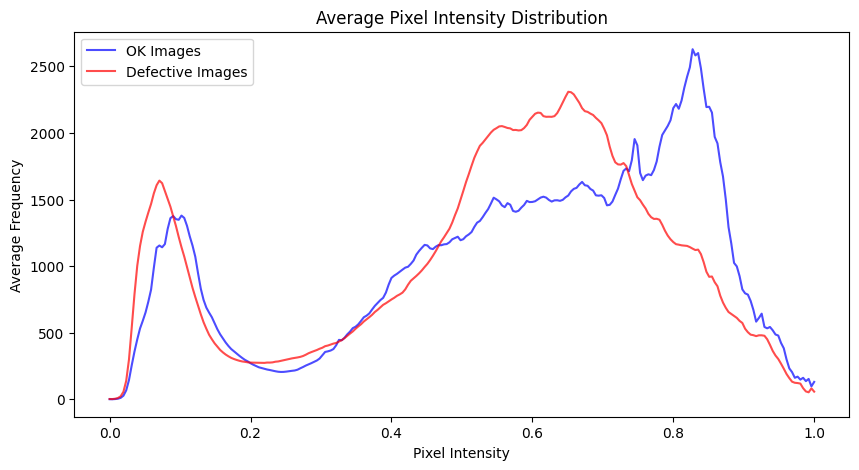

In [7]:
def plot_avg_intensity_histogram(ok_images: list, defect_images: list) -> None:
    """
    Plot the average pixel intensity distribution for two sets of images:
    one for OK images and one for defective images.

    Parameters:
    -----------
    ok_images : List[str]
        A list of file paths to the "OK" images to be processed.
    defect_images : List[str]
        A list of file paths to the "Defective" images to be processed.

    Returns:
    --------
    None
        This function does not return anything, it just displays the histogram plot.
    """
    ok_hist = np.zeros(256)
    defect_hist = np.zeros(256)

    for img_path in ok_images:
        img = imread(img_path, as_gray=True)
        hist, _ = np.histogram(img.ravel(), bins=256, range=(0, 1))
        ok_hist += hist

    for img_path in defect_images:
        img = imread(img_path, as_gray=True)
        hist, _ = np.histogram(img.ravel(), bins=256, range=(0, 1))
        defect_hist += hist

    ok_hist /= len(ok_images)
    defect_hist /= len(defect_images)

    plt.figure(figsize=(10, 5))
    plt.plot(
        np.linspace(0, 1, 256), ok_hist, label="OK Images", color="blue", alpha=0.7
    )
    plt.plot(
        np.linspace(0, 1, 256),
        defect_hist,
        label="Defective Images",
        color="red",
        alpha=0.7,
    )

    plt.title("Average Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Average Frequency")
    plt.legend()
    plt.show()


plot_avg_intensity_histogram(ok_images, defect_images)

- OK discs show higher frequency of pixel intensities in the range 0.7 to 0.9, indicating a smoother and more uniform surface.
- Defective discs have a more spread-out distribution, suggesting greater variations in brightness due to surface irregularities.

This pattern confirms that defects introduce more texture and contrast variations, making them visually distinguishable from defect-free discs.

### Structural Differences using Fourier Transform

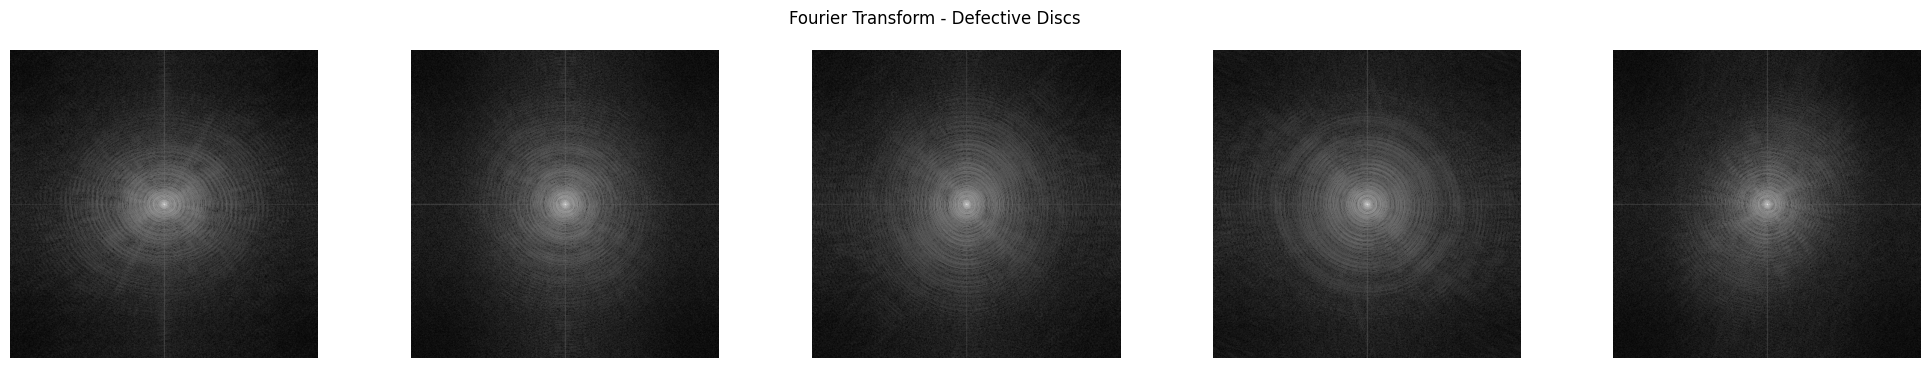

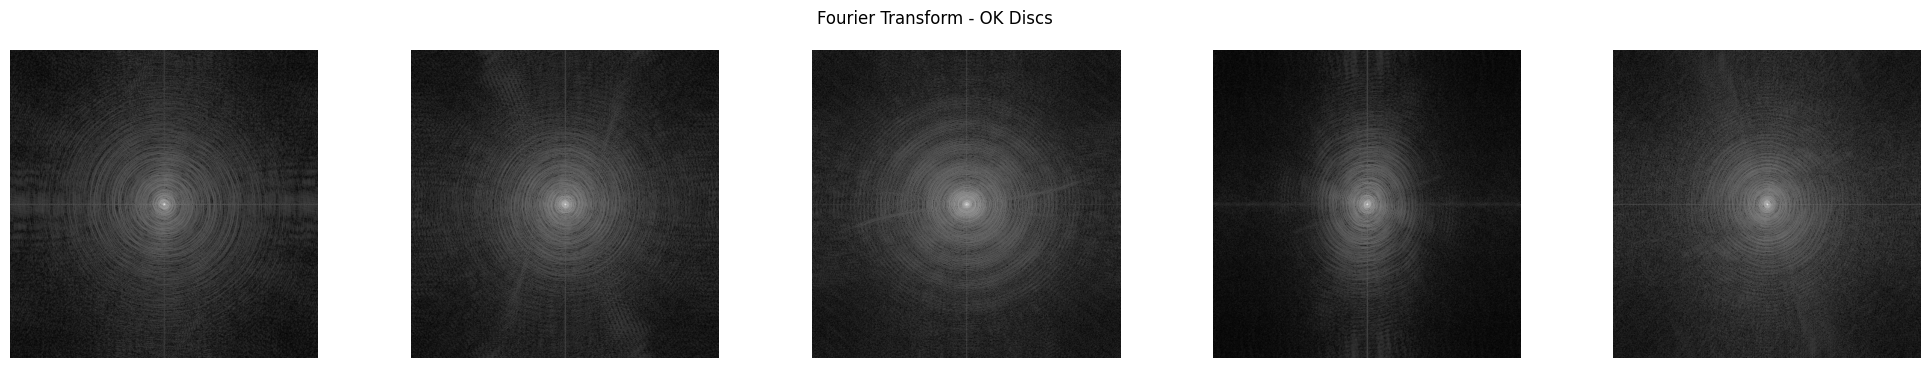

In [8]:
def show_fourier_transform(image_paths: list, title: str) -> None:
    """
    Show the Fourier transform of the images in the provided list.

    Parameters:
    -----------
    image_paths : List[str]
        A list of file paths to the images that will be processed and displayed.
    title : str
        The title of the plot to be displayed.

    Returns:
    --------
    None
        This function does not return anything, it just displays the Fourier transform plot.
    """
    fig, axes = plt.subplots(1, len(image_paths), figsize=(25, 4))
    for i, img_path in enumerate(image_paths):
        img = imread(img_path, as_gray=True)
        f_transform = np.log(np.abs(fftshift(fft2(img))) + 1)
        axes[i].imshow(f_transform, cmap="gray")
        axes[i].axis("off")
    plt.suptitle(title)
    plt.show()


show_fourier_transform(defect_images[:5], "Fourier Transform - Defective Discs")
show_fourier_transform(ok_images[:5], "Fourier Transform - OK Discs")

- OK Discs exhibit a more symmetric frequency pattern, indicating a structured and uniform surface.
- Defective Discs display less symmetry and more scattered frequency components, suggesting random irregularities and sharper edges.

<a id="feature_engineering"></a>
# 4. Feature Engineering

### Pixel Intensity Features

In [9]:
def pixel_intensity_stats(image: np.ndarray) -> tuple:
    """
    Calculate the pixel intensity statistics of an image.

    Parameters:
    -----------
    image : np.ndarray
        A 2D NumPy array representing the grayscale image.

    Returns:
    --------
    tuple
        A tuple containing the following statistics:
        - Mean intensity: The average pixel intensity of the image.
        - Variance: The variance of pixel intensities in the image.
        - Skewness: The skewness of pixel intensities (a measure of asymmetry).
        - Kurtosis: The kurtosis of pixel intensities (a measure of the "tailedness").
    """
    mean_intensity = np.mean(image)
    variance = np.var(image)
    skewness = skew(image.flatten())
    kurt = kurtosis(image.flatten())

    return mean_intensity, variance, skewness, kurt


img = io.imread(defect_images[0], as_gray=True)
mean, variance, skewness, kurt = pixel_intensity_stats(img)
print(
    f"Def - Mean: {mean}, Variance: {variance}, Skewness: {skewness}, Kurtosis: {kurt}"
)

img = io.imread(ok_images[0], as_gray=True)
mean, variance, skewness, kurt = pixel_intensity_stats(img)
print(
    f"Ok  - Mean: {mean}, Variance: {variance}, Skewness: {skewness}, Kurtosis: {kurt}"
)

Def - Mean: 0.5160055123123468, Variance: 0.04844330601345123, Skewness: -0.8007412246148815, Kurtosis: -0.12548088890284426
Ok  - Mean: 0.6558444303624769, Variance: 0.06098041151551404, Skewness: -1.063142666018699, Kurtosis: -0.10483114903101853


Possible observations:
- OK Discs have a higher mean intensity, meaning they are generally brighter.
- Defective Discs have lower variance, indicating less contrast in intensity.
- Skewness values suggest that both distributions lean towards darker pixels, but defective discs have a slightly less negative skew.
- Kurtosis values are negative for both, indicating a flatter intensity distribution compared to a normal distribution.

### Edge Detection Features

In [10]:
def compute_edge_features(image: np.ndarray, threshold: float = 0.2) -> int:
    """
    Compute edge features of an image using the Sobel operator and a threshold.

    Parameters:
    -----------
    image : np.ndarray
        A 2D NumPy array representing the grayscale image.
    threshold : float, optional
        A threshold value for edge detection. Default is 0.2.

    Returns:
    --------
    int
        The count of pixels detected as edges after applying the Sobel operator and thresholding.
    """
    edges = sobel(image)
    edges_thresholded = edges > threshold
    edge_count = np.sum(edges_thresholded > 0)
    return edge_count


img = imread(defect_images[0], as_gray=True)
edge_count = compute_edge_features(img)
print("Def Edge Count:", edge_count)

img = imread(ok_images[0], as_gray=True)
edge_count = compute_edge_features(img)
print("Ok Edge Count:", edge_count)

Def Edge Count: 9274
Ok Edge Count: 2781


- Defective Discs exhibit a significantly higher edge count.
- The defects likely create irregular shapes and sharper transitions, which result in an increase in detected edges.

### Texture Features (GLCM)

In [11]:
def compute_texture_features(image: np.ndarray) -> tuple:
    """
    Compute texture features from a grayscale image using Gray Level Co-occurrence Matrix (GLCM).

    Parameters:
    -----------
    image : np.ndarray
        A 2D NumPy array representing the grayscale image.

    Returns:
    --------
    tuple
        A tuple containing four texture features:
        - contrast: Contrast of the image.
        - correlation: Correlation of the image.
        - energy: Energy of the image.
        - homogeneity: Homogeneity of the image.
    """
    image_uint8 = (image * 255).astype(np.uint8)
    glcm = graycomatrix(
        image_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True
    )
    contrast = graycoprops(glcm, "contrast")[0, 0]
    correlation = graycoprops(glcm, "correlation")[0, 0]
    energy = graycoprops(glcm, "energy")[0, 0]
    homogeneity = graycoprops(glcm, "homogeneity")[0, 0]
    return contrast, correlation, energy, homogeneity


img = imread(defect_images[0], as_gray=True)
contrast, correlation, energy, homogeneity = compute_texture_features(img)
print(
    "Def - Texture Features - Contrast:",
    contrast,
    "Correlation:",
    correlation,
    "Energy:",
    energy,
    "Homogeneity:",
    homogeneity,
)

img = imread(ok_images[0], as_gray=True)
contrast, correlation, energy, homogeneity = compute_texture_features(img)
print(
    "Ok - Texture Features - Contrast:",
    contrast,
    "Correlation:",
    correlation,
    "Energy:",
    energy,
    "Homogeneity:",
    homogeneity,
)

Def - Texture Features - Contrast: 114.23796783268101 Correlation: 0.9818947913443818 Energy: 0.04547123686449756 Homogeneity: 0.4956870737544769
Ok - Texture Features - Contrast: 43.134261099559694 Correlation: 0.9945639545197892 Energy: 0.088871077778804 Homogeneity: 0.7042780071260664


- Defective discs have significantly higher contrast, indicating greater pixel intensity variations.
- Lower homogeneity in defective discs suggests more irregular textures.
- Energy is lower in defective discs, implying higher randomness in texture distribution.
- Correlation is slightly lower for defects, reflecting weaker pixel relationships.

### Morphological Features (Shape Descriptors)

In [13]:
def compute_morphological_features(image: np.ndarray, threshold: float = 0.2) -> tuple:
    """
    Compute morphological features of the largest region in an edge-detected image.

    Parameters:
    -----------
    image : np.ndarray
        A 2D NumPy array representing the grayscale image.

    threshold : float, optional
        A threshold value for edge detection using the Sobel filter. Default is 0.2.

    Returns:
    --------
    tuple
        A tuple containing four morphological features:
        - area: Area of the largest connected region.
        - perimeter: Perimeter of the largest connected region.
        - aspect_ratio: Aspect ratio of the largest region.
        - circularity: Circularity of the largest region.
    """
    edges = sobel(image) > 0.2
    labeled_img = label(edges)
    regions = regionprops(labeled_img)

    if regions:
        largest_region = max(regions, key=lambda r: r.area)
        area = largest_region.area
        perimeter = largest_region.perimeter
        aspect_ratio = largest_region.major_axis_length / (
            largest_region.minor_axis_length + 1e-5
        )
        circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0
    else:
        area, perimeter, aspect_ratio, circularity = 0, 0, 0, 0

    return area, perimeter, aspect_ratio, circularity


img = imread(defect_images[0], as_gray=True)
area, perimeter, aspect_ratio, circularity = compute_morphological_features(img)
print(
    "Def - Area:",
    area,
    "Perimeter:",
    perimeter,
    "Aspect ratio:",
    aspect_ratio,
    "Circularity",
    circularity,
)

img = imread(ok_images[0], as_gray=True)
area, perimeter, aspect_ratio, circularity = compute_morphological_features(img)
print(
    "Ok - Area:",
    area,
    "Perimeter:",
    perimeter,
    "Aspect ratio:",
    aspect_ratio,
    "Circularity",
    circularity,
)

Def - Area: 1104.0 Perimeter: 826.2264427649427 Aspect ratio: 1.263096682361472 Circularity 0.02032266962616415
Ok - Area: 577.0 Perimeter: 491.53910524340097 Aspect ratio: 1.113607799874544 Circularity 0.030010244103687744


Possible observarions:
- Defective discs have larger area and perimeter, indicating more complex, irregular shapes.
- Higher aspect ratio in defective discs suggests elongated, non-uniform defects.
- Lower circularity in defective discs confirms that defects disrupt the smooth circular shape of the disc.


### Laplacian Variance (Blur Detection)

In [14]:
def compute_blur_feature(image: np.ndarray) -> float:
    """
    Compute the blur feature of the image using the variance of the Laplacian filter.

    The variance of the Laplacian is used to quantify the sharpness of the image:
    a higher variance indicates a sharper image, while a lower variance indicates a more blurred image.

    Parameters:
    -----------
    image : np.ndarray
        A 2D NumPy array representing the grayscale image.

    Returns:
    --------
    float
        The variance of the Laplacian, which is used to quantify the blur of the image.
    """
    laplacian_var = laplace(image).var()
    return laplacian_var


img = imread(defect_images[0], as_gray=True)
laplacian_var = compute_blur_feature(img)
print("Def - ", laplacian_var)

img = imread(ok_images[0], as_gray=True)
laplacian_var = compute_blur_feature(img)
print("Ok - ", laplacian_var)

Def -  0.0023963967528264373
Ok -  0.0026597444445570807


- The OK disc images have a slightly higher Laplacian variance compared to the defective disc images.
- This suggests that OK images are slightly sharper, while defective images show more blur due to imperfections and irregularities in the disc surface.

### Haralick Features (Texture Complexity)

In [15]:
def compute_haralick_features(image: np.ndarray) -> tuple:
    """
    Compute the Haralick texture features of the image using the Gray-Level Co-occurrence Matrix (GLCM).

    The GLCM is used to extract several texture features such as contrast, correlation, energy, and homogeneity.
    These features capture different aspects of the texture in the image, which can be useful for image classification and analysis.

    Parameters:
    -----------
    image : np.ndarray
        A 2D NumPy array representing the grayscale image.

    Returns:
    --------
    tuple
        A tuple containing the computed Haralick features: contrast, correlation, energy, and homogeneity.
    """
    glcm = graycomatrix(
        (image * 255).astype(np.uint8),
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True,
    )
    contrast = graycoprops(glcm, "contrast")[0, 0]
    correlation = graycoprops(glcm, "correlation")[0, 0]
    energy = graycoprops(glcm, "energy")[0, 0]
    homogeneity = graycoprops(glcm, "homogeneity")[0, 0]
    return contrast, correlation, energy, homogeneity


img = imread(defect_images[0], as_gray=True)
contrast, correlation, energy, homogeneity = compute_haralick_features(img)
print(
    f"Def - Contrast: {contrast}, Correlation: {correlation}, Energy: {energy}, Homogeneity: {homogeneity}"
)

img = imread(ok_images[0], as_gray=True)
contrast, correlation, energy, homogeneity = compute_haralick_features(img)
print(
    f"Ok - Contrast: {contrast}, Correlation: {correlation}, Energy: {energy}, Homogeneity: {homogeneity}"
)

Def - Contrast: 114.23796783268101, Correlation: 0.9818947913443818, Energy: 0.04547123686449756, Homogeneity: 0.4956870737544769
Ok - Contrast: 43.134261099559694, Correlation: 0.9945639545197892, Energy: 0.088871077778804, Homogeneity: 0.7042780071260664


- Defective Discs:
  - Higher contrast indicates more variation in pixel intensities and suggests a more irregular texture.
  - Lower energy and homogeneity suggest that the image has more complex or less uniform texture, which is typical of defective discs with imperfections.
  - Lower correlation means the pixel intensities are less correlated, further supporting the idea of irregularities in the surface.
  
- OK Discs:
  - Lower contrast implies a smoother and more uniform texture.
  - Higher homogeneity indicates a more uniform pixel distribution across the image, typical of the smoother surface of non-defective discs.
  - Higher energy reflects a more uniform and regular texture.
  - Higher correlation suggests a more predictable and consistent relationship between neighboring pixels, characteristic of the smoother, less noisy surfaces of OK discs.


### Local Binary Patterns (LBP)

In [16]:
def compute_lbp_features(image: np.ndarray, P: int = 8, R: int = 1) -> np.ndarray:
    """
    Compute the Local Binary Pattern (LBP) features of the image.

    LBP is a texture descriptor that labels the pixels of an image by thresholding the neighborhood of each pixel
    with the center value and then converting the result into a binary number. The uniform patterns are used to form
    a histogram which captures the texture features.

    Parameters:
    -----------
    image : np.ndarray
        A 2D NumPy array representing the grayscale image.
    P : int, optional (default=8)
        The number of circularly symmetric neighbor set points (P).
    R : int, optional (default=1)
        The radius of the circle (R).

    Returns:
    --------
    np.ndarray
        A normalized histogram representing the LBP features of the image.
    """
    image_uint8 = (image * 255).astype(np.uint8)
    lbp = local_binary_pattern(image_uint8, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    hist = hist.astype("float")
    hist /= hist.sum()
    return hist


img = imread(defect_images[0], as_gray=True)
hist = compute_lbp_features(img)
print("Def - ", hist)

img = imread(ok_images[0], as_gray=True)
hist = compute_lbp_features(img)
print("Ok - ", hist)

Def -  [0.01670456 0.05054092 0.02370071 0.10830688 0.18100357 0.22518158
 0.08654785 0.07320786 0.14540482 0.08940125]
Ok -  [0.01114273 0.02817154 0.00825882 0.0701561  0.06732559 0.22081375
 0.04344177 0.06406784 0.44094086 0.045681  ]


- Defective Discs:
  - The LBP histogram for defective discs shows a higher frequency of middle-range patterns, with a more even distribution of texture features (i.e., the values between 0.05 and 0.20).
  - The prominent peaks in the middle indicate more variation and irregularity in the texture, which is expected in defective discs.

- OK Discs:
  - The LBP histogram for OK discs has a higher frequency in the higher bins (around 0.4), suggesting that the texture is more uniform and regular, with fewer complex patterns.
  - The texture is smoother with fewer abrupt changes, which corresponds to the uniformity of the surface of non-defective discs.


### Fractal Dimension (Complexity of Structure)

In [17]:
def compute_fractal_dimension(image: np.ndarray, threshold: float = 0.9) -> float:
    """
    Compute the fractal dimension of the image using box-counting method.

    Fractal dimension measures the complexity or roughness of an image's structure. The box-counting method calculates
    the number of boxes of different sizes needed to cover the shape, and uses the scaling behavior to estimate the
    fractal dimension.

    Parameters:
    -----------
    image : np.ndarray
        A 2D NumPy array representing the grayscale image.
    threshold : float, optional (default=0.9)
        The threshold value to binarize the image. All pixel values above this threshold will be set to True, and all
        values below it will be set to False.

    Returns:
    --------
    float
        The fractal dimension of the image.
    """
    binary_image = image > threshold
    sizes = np.array([2, 4, 8, 16, 32])
    counts = []

    for size in sizes:
        blocks = binary_image[
            : binary_image.shape[0] // size * size,
            : binary_image.shape[1] // size * size,
        ]
        counts.append(np.sum(blocks.reshape(-1, size, size).any(axis=(1, 2))))

    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


img = imread(defect_images[0], as_gray=True)
fractal_feature = compute_fractal_dimension(img)
print("Def - ", fractal_feature)

img = imread(ok_images[0], as_gray=True)
fractal_feature = compute_fractal_dimension(img)
print("Ok - ", fractal_feature)

Def -  0.4778089713778806
Ok -  1.0882751210218475


- The fractal dimension of OK discs is higher, suggesting that the texture of non-defective discs is more uniform and smoother, leading to a more regular structure and a higher fractal dimension.

<a id="models"></a>
# 5. Models

<a id="model_architecture"></a>
## 5.1. Data Pipeline and Model Architecture Configuration

### FeatureExtractor Class
- pixel_intensity_stats(image):
    - Purpose: Computes basic statistical features of pixel intensities in the image.
    - Returns: Mean intensity, variance, skewness, and kurtosis.

- compute_edge_features(image):
    - Purpose: Computes edge-related features using the Sobel operator at different threshold levels.
    - Returns: Edge count at three different thresholds (0.1, 0.2, 0.3).

- compute_texture_features(image):
    - Purpose: Extracts texture-related features using the Gray Level Co-occurrence Matrix (GLCM).
    - Returns: Contrast, correlation, energy, and homogeneity.

- compute_fourier_features(image):
    - Purpose: Analyzes the frequency domain of the image by applying a Fourier transform.
    - Returns: Count of high-frequency components in the Fourier transform.

- compute_histogram_features(image):
    - Purpose: Analyzes the pixel intensity histogram of the image.
    - Returns: Skewness, kurtosis, and entropy of the histogram.

- compute_morphological_features(image):
    - Purpose: Computes morphological features, such as area, perimeter, aspect ratio, and circularity, from detected edges.
    - Returns: Area, perimeter, aspect ratio, and circularity of the largest edge component.

- compute_blur_feature(image):
    - Purpose: Computes the degree of image blurriness using the variance of the Laplacian.
    - Returns: Laplacian variance, which quantifies image sharpness.

- compute_haralick_features(image):
    - Purpose: Extracts Haralick texture features from the GLCM.
    - Returns: Contrast, correlation, energy, and homogeneity (similar to compute_texture_features but uses a different method).

- compute_lbp_features(image, P=8, R=1):
    - Purpose: Computes Local Binary Pattern (LBP) features, which are useful for texture classification.
    - Returns: Normalized histogram of LBP values.

- compute_fractal_dimension(image, threshold=0.9):
    - Purpose: Computes the fractal dimension of the image using a box-counting method.
    - Returns: Fractal dimension value, indicating the complexity of the image texture.

- extract_features(image):
    - Purpose: Extracts all the aforementioned features from a single image. This method combines the results of each individual feature extraction method into a single feature vector.
    - Returns: A comprehensive feature vector containing all the extracted features.

In [ ]:
class FeatureExtractor:
    """
    A class for extracting a comprehensive set of features from a grayscale image.

    This class provides methods to extract various types of features from an input image,
    including pixel intensity statistics, edge features, texture features, Fourier features,
    histogram features, morphological features, blur detection, Haralick texture features,
    Local Binary Pattern (LBP) features, and fractal dimension.

    The extracted features can be used for image analysis, pattern recognition, and classification tasks.
    """

    def __init__(self):
        pass

    def pixel_intensity_stats(self, image: np.ndarray) -> tuple:
        """
        Calculate statistical properties of pixel intensity (mean, variance, skewness, kurtosis).

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        tuple
            mean_intensity, variance, skewness, kurtosis of the image.
        """
        mean_intensity = np.mean(image)
        variance = np.var(image)
        skewness = skew(image.flatten())
        kurt_value = kurtosis(image.flatten())
        return mean_intensity, variance, skewness, kurt_value

    def compute_edge_features(self, image: np.ndarray) -> tuple:
        """
        Compute the number of edges in the image at different threshold values.

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        tuple
            Three edge count values for different threshold levels (0.1, 0.2, 0.3).
        """
        edges = sobel(image)

        threshold_1 = 0.1
        edges_thresholded_1 = edges > threshold_1
        edge_count_1 = np.sum(edges_thresholded_1 > 0)

        threshold_2 = 0.2
        edges_thresholded_2 = edges > threshold_2
        edge_count_2 = np.sum(edges_thresholded_2 > 0)

        threshold_3 = 0.3
        edges_thresholded_3 = edges > threshold_3
        edge_count_3 = np.sum(edges_thresholded_3 > 0)

        return edge_count_1, edge_count_2, edge_count_3

    def compute_texture_features(self, image: np.ndarray) -> tuple:
        """
        Compute texture features using Gray-Level Co-occurrence Matrix (GLCM).

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        tuple
            Contrast, correlation, energy, and homogeneity computed from GLCM.
        """
        image_uint8 = (image * 255).astype(np.uint8)
        glcm = graycomatrix(
            image_uint8,
            distances=[1],
            angles=[0],
            levels=256,
            symmetric=True,
            normed=True,
        )
        contrast = graycoprops(glcm, "contrast")[0, 0]
        correlation = graycoprops(glcm, "correlation")[0, 0]
        energy = graycoprops(glcm, "energy")[0, 0]
        homogeneity = graycoprops(glcm, "homogeneity")[0, 0]
        return contrast, correlation, energy, homogeneity

    def compute_fourier_features(self, image: np.ndarray) -> int:
        """
        Compute high frequency components of the image using Fourier Transform.

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        int
            The count of high-frequency components (percentile above 95).
        """
        f_transform = np.abs(fftshift(fft2(image)))
        high_freq_count = np.sum(f_transform > np.percentile(f_transform, 95))
        return high_freq_count

    def compute_histogram_features(self, image: np.ndarray) -> tuple:
        """
        Compute statistical features from the image histogram.

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        tuple
            Skewness, kurtosis, and entropy of the histogram.
        """
        hist_values, _ = np.histogram(image, bins=256, range=(0, 1))
        skewness = stats.skew(hist_values)
        kurtosis = stats.kurtosis(hist_values)
        entropy = stats.entropy(hist_values)
        return skewness, kurtosis, entropy

    def compute_morphological_features(self, image: np.ndarray) -> tuple:
        """
        Compute morphological features (area, perimeter, aspect ratio, circularity).

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        tuple
            Area, perimeter, aspect ratio, and circularity of the largest object detected.
        """
        edges = sobel(image) > 0.2
        labeled_img = label(edges)
        regions = regionprops(labeled_img)

        if regions:
            largest_region = max(regions, key=lambda r: r.area)
            area = largest_region.area
            perimeter = largest_region.perimeter
            aspect_ratio = largest_region.major_axis_length / (
                largest_region.minor_axis_length + 1e-5
            )
            circularity = (4 * np.pi * area) / (perimeter**2) if perimeter > 0 else 0
        else:
            area, perimeter, aspect_ratio, circularity = 0, 0, 0, 0

        return area, perimeter, aspect_ratio, circularity

    def compute_blur_feature(self, image: np.ndarray) -> float:
        """
        Compute the amount of blur in the image using the variance of the Laplacian.

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        float
            The variance of the Laplacian, representing the blur amount.
        """
        laplacian_var = laplace(image).var()
        return laplacian_var

    def compute_haralick_features(self, image: np.ndarray) -> tuple:
        """
        Compute Haralick texture features (contrast, correlation, energy, homogeneity).

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        tuple
            Haralick texture features: contrast, correlation, energy, and homogeneity.
        """
        glcm = graycomatrix(
            (image * 255).astype(np.uint8),
            distances=[1],
            angles=[0],
            levels=256,
            symmetric=True,
            normed=True,
        )
        contrast = graycoprops(glcm, "contrast")[0, 0]
        correlation = graycoprops(glcm, "correlation")[0, 0]
        energy = graycoprops(glcm, "energy")[0, 0]
        homogeneity = graycoprops(glcm, "homogeneity")[0, 0]
        return contrast, correlation, energy, homogeneity

    def compute_lbp_features(
        self, image: np.ndarray, P: int = 8, R: int = 1
    ) -> np.ndarray:
        """
        Compute Local Binary Pattern (LBP) features.

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.
        P : int, optional (default=8)
            The number of circularly symmetric neighbor set points (P).
        R : int, optional (default=1)
            The radius of the circular neighborhood (R).

        Returns:
        --------
        np.ndarray
            LBP histogram of the image.
        """
        image_uint8 = (image * 255).astype(np.uint8)
        lbp = local_binary_pattern(image_uint8, P, R, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        hist = hist.astype("float")
        hist /= hist.sum()
        return hist

    def compute_fractal_dimension(
        self, image: np.ndarray, threshold: float = 0.9
    ) -> float:
        """
        Compute the fractal dimension of the image using box-counting method.

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.
        threshold : float, optional (default=0.9)
            Threshold for binarizing the image before counting boxes.

        Returns:
        --------
        float
            The fractal dimension of the image.
        """
        binary_image = image > threshold
        sizes = np.array([2, 4, 8, 16, 32])
        counts = []

        for size in sizes:
            blocks = binary_image[
                : binary_image.shape[0] // size * size,
                : binary_image.shape[1] // size * size,
            ]
            counts.append(np.sum(blocks.reshape(-1, size, size).any(axis=(1, 2))))

        coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
        return -coeffs[0]

    def extract_features(self, image: np.ndarray) -> list:
        """
        Extract a comprehensive set of features from the image.

        Parameters:
        -----------
        image : np.ndarray
            Grayscale image as a 2D numpy array.

        Returns:
        --------
        list
            List of all the computed features from pixel intensity stats, edges, texture, Fourier transform,
            histogram, morphological, blur, Haralick, LBP, and fractal dimension.
        """
        pixel_stats = self.pixel_intensity_stats(image)
        edge_count = self.compute_edge_features(image)
        texture_features = self.compute_texture_features(image)
        fourier_features = self.compute_fourier_features(image)
        histogram_features = self.compute_histogram_features(image)
        morphological_features = self.compute_morphological_features(image)
        blur_feature = self.compute_blur_feature(image)
        haralick_features = self.compute_haralick_features(image)
        lbp_features = self.compute_lbp_features(image)
        fractal_feature = self.compute_fractal_dimension(image)

        features = (
            list(pixel_stats)
            + list(edge_count)
            + list(texture_features)
            + [fourier_features]
            + list(histogram_features)
            + list(morphological_features)
            + [blur_feature]
            + list(haralick_features)
            + list(lbp_features)
            + [fractal_feature]
        )

        return features

### Data Loader Class
- The DefectDataModule class handles the entire process of image data feature extraction, splitting, and batching for model training, validation, and testing.

In [ ]:
L.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


def seed_worker(worker_id: int):
    """
    Sets the seed for random number generators in numpy, random, and PyTorch for a specific worker.

    This function is used to ensure that each worker in a multi-worker data loading setup
    (e.g., with DataLoader in PyTorch) gets a unique seed, which allows for reproducibility
    and parallel processing without the risk of workers sharing the same random numbers.

    Args:
    ----------
    worker_id : int
        The identifier for the worker. This ID is used to ensure each worker has a unique seed.

    Notes:
    ------
    The worker seed is derived from the initial seed of PyTorch (`torch.initial_seed()`) and
    is then used to seed the random number generators in numpy and Python's random module,
    ensuring each worker has a different random state.
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


class DefectDataModule(L.LightningDataModule):
    """
    A PyTorch Lightning DataModule for loading and processing a dataset of images related to casting defects.
    This class handles data loading, feature extraction, and dataset splitting into training, validation,
    and test sets for a binary classification task.

    Args:
    ----------
    image_folder : str
        The path to the folder containing the image dataset. It should contain subfolders 'def_front' and 'ok_front'.

    batch_size : int, optional (default=64)
        The batch size to be used for data loading during training and evaluation.
    """

    def __init__(self, image_folder: str, batch_size: int = 64):
        """
        Initializes the data module, extracts features from the images in the given folder,
        and prepares the dataset for training and evaluation.

        Args:
        ----------
        image_folder : str
            Path to the directory containing the image dataset.

        batch_size : int, optional (default=64)
            Batch size for loading data.
        """
        super().__init__()
        self.image_folder = image_folder
        self.batch_size = batch_size
        self.feature_extractor = FeatureExtractor()
        self.data = self.extract_features_from_directory()

    def prepare_data(self):
        """
        Prepares the dataset for training by ensuring no heavy computation is required.
        In this case, the dataset is precomputed and stored in a CSV format.
        """
        pass

    def extract_features_from_directory(self) -> pd.DataFrame:
        """
        Extracts features from images in the dataset located in the provided image folder.
        Features are extracted from images in subdirectories 'def_front' and 'ok_front' and stored in a DataFrame.

        This method reads each image, applies feature extraction, and labels the images based on their folder.

        Returns:
        --------
        pd.DataFrame
            A DataFrame containing the extracted features along with image paths and labels.
        """
        features_list = []

        for folder in ["def_front", "ok_front"]:
            folder_path = os.path.join(self.image_folder, folder)
            target_label = 1 if folder == "def_front" else 0

            for image_filename in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_filename)

                if os.path.isdir(image_path) or not image_filename.endswith(
                    (".png", ".jpg", ".jpeg", ".bmp")
                ):
                    continue

                image_id = int(image_filename.split("_")[-1].split(".")[0])

                image = imread(image_path, as_gray=True)
                image_features = self.feature_extractor.extract_features(image)
                features_list.append(
                    [image_path, image_id, folder, target_label] + image_features
                )

        feature_columns = [
            "image_path",
            "image_id",
            "folder",
            "target",
            "mean_intensity",
            "variance",
            "skewness",
            "kurtosis",
            "edge_count_1",
            "edge_count_2",
            "edge_count_3",
            "contrast",
            "correlation",
            "energy",
            "homogeneity",
            "high_freq_count",
            "histogram_skewness",
            "histogram_kurtosis",
            "histogram_entropy",
            "area",
            "perimeter",
            "aspect_ratio",
            "circularity",
            "laplacian_var",
            "contrast",
            "correlation",
            "energy",
            "homogeneity",
            "lbp_bin_0",
            "lbp_bin_1",
            "lbp_bin_2",
            "lbp_bin_3",
            "lbp_bin_4",
            "lbp_bin_5",
            "lbp_bin_6",
            "lbp_bin_7",
            "lbp_bin_8",
            "lbp_bin_9",
            "fractal_feature",
        ]

        features_df = pd.DataFrame(features_list, columns=feature_columns)
        return features_df

    def setup(self, stage: str = None):
        """
        Prepares the data for training, validation, and testing by splitting the features into training,
        validation, and test sets, and normalizing them.

        The data is then converted into PyTorch datasets that can be used by DataLoader for training and evaluation.

        Args:
        ----------
        stage : str, optional
            The stage of the pipeline (e.g., 'fit', 'test') to determine which datasets should be prepared.
        """
        labels = self.data["target"].values
        features = self.data.drop(
            columns=["image_path", "image_id", "folder", "target"]
        ).values
        image_paths = self.data[["image_id", "target"]].values

        features = (features - np.mean(features, axis=0)) / np.std(features, axis=0)

        X_train, X_temp, y_train, y_temp, _, path_temp = train_test_split(
            features,
            labels,
            image_paths,
            test_size=0.70,
            stratify=labels,
            random_state=42,
        )
        X_val, X_test, y_val, y_test, _, path_test = train_test_split(
            X_temp, y_temp, path_temp, test_size=4 / 7, stratify=y_temp, random_state=42
        )

        self.train_dataset = TensorDataset(
            torch.tensor(X_train, dtype=torch.float32),
            torch.tensor(y_train, dtype=torch.long),
        )
        self.val_dataset = TensorDataset(
            torch.tensor(X_val, dtype=torch.float32),
            torch.tensor(y_val, dtype=torch.long),
        )
        self.test_dataset = TensorDataset(
            torch.tensor(X_test, dtype=torch.float32),
            torch.tensor(y_test, dtype=torch.long),
            torch.tensor(path_test, dtype=torch.int64),
        )

    def train_dataloader(self) -> DataLoader:
        """
        Returns the DataLoader for the training dataset.

        The DataLoader loads batches of training data with the specified batch size and shuffle setting.

        Returns:
        --------
        DataLoader
            The DataLoader instance for the training dataset.
        """
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=4,
            persistent_workers=True,
        )

    def val_dataloader(self) -> DataLoader:
        """
        Returns the DataLoader for the validation dataset.

        The DataLoader loads batches of validation data with the specified batch size.

        Returns:
        --------
        DataLoader
            The DataLoader instance for the validation dataset.
        """
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=4,
            persistent_workers=True,
        )

    def test_dataloader(self) -> DataLoader:
        """
        Returns the DataLoader for the test dataset.

        The DataLoader loads batches of test data with the specified batch size.

        Returns:
        --------
        DataLoader
            The DataLoader instance for the test dataset.
        """
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=4,
            persistent_workers=True,
        )

Seed set to 42


### Model LightningModel

- The model is created using a sequence of fully connected layers (nn.Linear) with batch normalization, activation functions, and dropout layers for regularization. The architecture consists of several hidden layers with configurable sizes, followed by a final output layer with a sigmoid activation to predict a binary output (defect or no defect).
- The loss function used is binary cross-entropy (BCELoss), and accuracy metrics are tracked for training, validation, and testing using torchmetrics.Accuracy.
- test_step Method - Additional Functionality:
    - In addition to calculating the test loss and accuracy, the test_step method also saves images that are predicted as defective.
    - For images predicted as defective (prediction == 1), it calls the show_edge_detection() method, which applies edge detection and highlights the detected defect in the image by marking the defective regions based on predefined criteria (defect_criteria).
    - The resulting images are saved with defect annotations in a specified output folder.

In [ ]:
class LightningModel(L.LightningModule):
    """
    A PyTorch Lightning model for binary classification using a fully connected neural network.
    The model takes image features as input and predicts whether the image contains a defect or not.
    """

    def __init__(
        self,
        num_features: int,
        hidden_layers: list,
        activation: torch.nn.Module,
        dropout_ratio: float,
        learning_rate: float = 0.01,
        optimizer_name: str = "Adam",
        weight_decay: float = 0.01,
    ):
        """
        Initializes the model architecture with the specified number of features, hidden layers, activation function,
        dropout ratio, optimizer, and other hyperparameters.

        Args:
        ----------
        num_features : int
            The number of input features to the model.

        hidden_layers : list of int
            A list containing the number of units in each hidden layer.

        activation : torch.nn.Module
            The activation function to be applied after each hidden layer.

        dropout_ratio : float
            The dropout ratio to be used after each hidden layer to prevent overfitting.

        learning_rate : float, optional (default=0.01)
            The learning rate for the optimizer.

        optimizer_name : str, optional (default="Adam")
            The optimizer to be used. Options are "Adam", "AdamW", and "SGD".

        weight_decay : float, optional (default=0.01)
            The weight decay (L2 regularization) to be used during optimization.
        """
        super().__init__()

        layers = []
        input_dim = num_features

        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(activation)
            layers.append(nn.Dropout(dropout_ratio))
            input_dim = hidden_dim

        layers.append(nn.Linear(input_dim, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.learning_rate = learning_rate
        self.optimizer_name = optimizer_name
        self.weight_decay = weight_decay
        self.loss_fn = nn.BCELoss()

        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")
        self.test_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model. This function defines how the input passes through the model.

        Args:
        ----------
        x : torch.Tensor
            The input features to the model.

        Returns:
        --------
        torch.Tensor
            The output of the model (predictions).
        """
        return self.model(x)

    def _shared_step(self, batch: tuple) -> tuple:
        """
        Shared step for training, validation, and test steps. Calculates the loss and accuracy.

        Args:
        ----------
        batch : tuple
            A batch of data, including input features and true labels.

        Returns:
        --------
        tuple
            A tuple containing the loss, true labels, and predicted labels.
        """
        features, true_labels = batch
        logits = self(features).squeeze()
        loss = self.loss_fn(logits, true_labels.float())
        preds = (logits > 0.5).long()
        return loss, true_labels, preds

    def training_step(self, batch: tuple, batch_idx: int) -> torch.Tensor:
        """
        Training step for the model. It calculates the loss, logs the accuracy,
        and updates the model's weights.

        Args:
        ----------
        batch : tuple
            A batch of training data, including input features and true labels.

        batch_idx : int
            The index of the batch during training.

        Returns:
        --------
        torch.Tensor
            The loss value for the current batch.
        """
        loss, true_labels, preds = self._shared_step(batch)
        self.log("train_loss", loss, prog_bar=True)
        self.train_acc(preds, true_labels)
        self.log(
            "train_acc", self.train_acc, prog_bar=True, on_epoch=True, on_step=False
        )
        return loss

    def validation_step(self, batch: tuple, batch_idx: int) -> None:
        """
        Validation step for the model. It calculates the loss and accuracy on the validation set.

        Args:
        ----------
        batch : tuple
            A batch of validation data, including input features and true labels.

        batch_idx : int
            The index of the batch during validation.

        Returns:
        --------
        None
        """
        loss, true_labels, preds = self._shared_step(batch)
        self.log("val_loss", loss, prog_bar=True)
        self.val_acc(preds, true_labels)
        self.log("val_acc", self.val_acc, prog_bar=True)

    def test_step(self, batch: tuple, batch_idx: int) -> None:
        """
        Test step for the model. It calculates the loss and accuracy on the test set and generates predictions.

        Args:
        ----------
        batch : tuple
            A batch of test data, including input features, true labels, and image paths.

        batch_idx : int
            The index of the batch during testing.

        Returns:
        --------
        None
        """
        features, true_labels, image_paths = batch
        loss, true_labels, preds = self._shared_step((features, true_labels))
        self.test_acc(preds, true_labels)
        self.log("test_acc", self.test_acc)

        for (id, target), prediction in zip(image_paths, preds):
            if prediction == 1:
                folder = "def" if target == 1 else "ok"
                file_path = f"data\\{folder}_front\\cast_{folder}_0_{id}.jpeg"
                output_file_path = f"data\\pred_def\\cast_{id}_{target}.jpeg"

                self.show_edge_detection(file_path, output_file_path)

    def show_edge_detection(self, image_path: str, output_path: str) -> None:
        """
        Performs edge detection on an image and saves the result, highlighting the defects.

        Args:
        ----------
        image_path : str
            Path to the input image.

        output_path : str
            Path to save the processed image with highlighted defects.

        Returns:
        --------
        None
        """
        img = imread(image_path, as_gray=True)

        edges = sobel(img) > 0.15
        labeled_img = label(edges)
        regions = regionprops(labeled_img)

        result_img = np.copy(img)

        for idx, region in enumerate(regions):
            if self.is_defect(region):
                minr, minc, maxr, maxc = region.bbox

                rr, cc = rectangle_perimeter(
                    start=(minr, minc), end=(maxr, maxc), shape=img.shape
                )
                result_img[rr, cc] = 0

        result_img = (result_img * 255).astype(np.uint8)
        result_img_pil = Image.fromarray(result_img)

        result_img_pil.save(output_path, format="JPEG")

    def is_defect(self, region) -> bool:
        """
        Check if the given region of the image matches defect criteria.

        Args:
        ----------
        region : skimage.measure.regionprops
            The region object containing properties of the labeled region.

        Returns:
        --------
        bool
            True if the region meets the defect criteria, False otherwise.
        """
        defect_criteria = {
            "min_area": 20,
            "max_area": 300,
            "min_area_vs_perimeter": 1,
            "max_circularity": 1.2,
            "eccentricity_threshold": 0.4,
        }
        if (
            region.area <= defect_criteria["min_area"]
            or region.area >= defect_criteria["max_area"]
        ):
            return False

        if region.area / region.perimeter < defect_criteria["min_area_vs_perimeter"]:
            return False

        if region.perimeter > 0:
            circularity = (4 * np.pi * region.area) / (region.perimeter**2)
        else:
            circularity = 0

        if circularity > defect_criteria["max_circularity"]:
            return False

        if region.eccentricity < defect_criteria["eccentricity_threshold"]:
            return False

        return True

    def configure_optimizers(self) -> torch.optim.Optimizer:
        """
        Configures the optimizer for training based on the specified optimizer name.

        Returns:
        --------
        torch.optim.Optimizer
            The optimizer to be used for training.
        """
        if self.optimizer_name == "SGD":
            return optim.SGD(
                self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
            )
        if self.optimizer_name == "AdamW":
            return optim.AdamW(
                self.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay
            )

<a id="process_images"></a>
## 5.2. Process Images to Data

In [21]:
start_time = time.time()
dm = DefectDataModule(image_folder="data", batch_size=64)
end_time = time.time()

image_count = len(os.listdir("data/def_front") + os.listdir("data/ok_front"))
duration = end_time - start_time
duration_per_image = duration / image_count
print(f"Data loading time: {duration:.2f} seconds")
print(f"Data loading time per image: {duration_per_image:.2f} seconds")

Data loading time: 199.17 seconds
Data loading time per image: 0.15 seconds


<a id="optuna"></a>
## 5.3. Optuna Configuration

#### Define an optimization objective for hyperparameter tuning in Optuna

In [ ]:
def objective(trial) -> float:
    """
    Objective function for hyperparameter optimization using Optuna.

    The function defines and trains a `LightningModel` with hyperparameters suggested by the Optuna trial,
    and returns the validation accuracy.

    Args:
    ----------
    trial : optuna.trial.Trial
        An Optuna trial object that suggests hyperparameters for optimization.

    Returns:
    --------
    float
        The validation accuracy obtained after training the model with the suggested hyperparameters.
    """
    optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "AdamW"])
    activation_str = trial.suggest_categorical("activation", ["ReLU", "LeakyReLU"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-1)
    dropout_ratio = trial.suggest_float("dropout_ratio", 0.1, 0.5)
    hidden_layers = trial.suggest_categorical(
        "hidden_layers", [(512, 256), (256, 128), (128, 64, 32)]
    )

    activation_fn = (
        nn.ReLU() if activation_str == "ReLU" else nn.LeakyReLU(negative_slope=0.01)
    )

    lightning_model = LightningModel(
        num_features=35,
        hidden_layers=list(hidden_layers),
        activation=activation_fn,
        dropout_ratio=dropout_ratio,
        learning_rate=learning_rate,
        optimizer_name=optimizer_name,
        weight_decay=weight_decay,
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath=f"optuna_checkpoints/trial_{trial.number}",
        filename="best_model",
        save_top_k=1,
        monitor="val_acc",
        mode="max",
    )

    early_stop_callback = EarlyStopping(
        monitor="val_accuracy", min_delta=0.00, patience=5, verbose=False, mode="max"
    )

    trainer = L.Trainer(
        max_epochs=40,
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        logger=CSVLogger(save_dir=f"logs/{trial.number}/", name="my-model"),
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=1,
    )

    trainer.fit(model=lightning_model, datamodule=dm)

    val_acc = trainer.validate(datamodule=dm, ckpt_path="best")[0]["val_acc"]

    return val_acc

1. Hyperparameter Suggestions:
   - optimizer_name: The optimizer to use ("SGD" or "AdamW").
   - activation_str: The activation function to use ("ReLU", "LeakyReLU").
   - learning_rate: The learning rate for the optimizer from 0.0001 to 0.1.
   - dropout_ratio: The dropout ratio to apply in the model from 0.1 to 0.5.
   - hidden_layers_str: The number of hidden layers in the model (512, 256), (256, 128), (128, 64, 32).
   
2. Model Architecture:
   - The number of hidden layers is set based on the hidden_layers_str:
     - 1: [512, 256] hidden layers.
     - 2: [256, 128] hidden layers.
     - 3: [128, 64, 32] hidden layers.
   
4. Activation Function Selection:
   - The activation function is chosen based on the activation_str:
     - "ReLU": nn.ReLU()
     - "LeakyReLU": nn.LeakyReLU(negative_slope=0.01)

This function defines an objective for Optuna to optimize the hyperparameters of a neural network model, including optimizer, batch size, activation function, and more. It trains the model with the suggested hyperparameters and returns the validation accuracy, which Optuna uses to select the best hyperparameter combination.


#### Search hyperparameters using Optuna

In [23]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=40)

[I 2025-03-02 13:59:25,413] A new study created in memory with name: no-name-79ef1515-ea92-4767-9918-7e1d2b7e54fb
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 42.42it/s, v_num=0, train_loss=0.762, val_loss=0.436, val_acc=0.856, train_acc=0.821]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 40.70it/s, v_num=0, train_loss=0.762, val_loss=0.436, val_acc=0.856, train_acc=0.821]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_0\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_0\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 122.80it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8641025424003601
        val_loss            0.44089755415916443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 13:59:42,925] Trial 0 finished with value: 0.8641025424003601 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.0017358674006804414, 'weight_decay': 0.0060119371430395665, 'dropout_ratio': 0.30299164106426174, 'hidden_layers': (512, 256)}. Best is trial 0 with value: 0.8641025424003601.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 15.4 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)
17        Modules in train mode


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.34it/s, v_num=0, train_loss=0.164, val_loss=0.199, val_acc=0.910, train_acc=0.926] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 26.72it/s, v_num=0, train_loss=0.164, val_loss=0.199, val_acc=0.910, train_acc=0.926]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_1\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_1\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 112.91it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9410256147384644
        val_loss            0.16397207975387573
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:00:00,304] Trial 1 finished with value: 0.9410256147384644 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.011403932085970696, 'weight_decay': 0.025641635298743116, 'dropout_ratio': 0.31528825125276394, 'hidden_layers': (128, 64, 32)}. Best is trial 1 with value: 0.9410256147384644.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in tra

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 41.42it/s, v_num=0, train_loss=0.410, val_loss=0.181, val_acc=0.918, train_acc=0.949]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 40.23it/s, v_num=0, train_loss=0.410, val_loss=0.181, val_acc=0.918, train_acc=0.949]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_2\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_2\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 87.50it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9564102292060852
        val_loss            0.12066193670034409
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:00:17,887] Trial 2 finished with value: 0.9564102292060852 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.007799091134322948, 'weight_decay': 0.00022171699225525553, 'dropout_ratio': 0.14922243271920577, 'hidden_layers': (512, 256)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mod

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 44.30it/s, v_num=0, train_loss=0.453, val_loss=0.197, val_acc=0.897, train_acc=0.915] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 42.94it/s, v_num=0, train_loss=0.453, val_loss=0.197, val_acc=0.897, train_acc=0.915]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_3\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_3\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 100.00it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9461538195610046
        val_loss            0.17387688159942627
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:00:34,377] Trial 3 finished with value: 0.9461538195610046 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.08593394937308978, 'weight_decay': 0.011461360638179582, 'dropout_ratio': 0.4133828839315187, 'hidden_layers': (512, 256)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 15.4 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)
17        Modules in train mode
0   

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 45.16it/s, v_num=0, train_loss=0.702, val_loss=0.650, val_acc=0.621, train_acc=0.631] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 39.11it/s, v_num=0, train_loss=0.702, val_loss=0.650, val_acc=0.621, train_acc=0.631]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_4\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_4\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 127.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.620512843132019
        val_loss            0.6499781012535095
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:00:50,589] Trial 4 finished with value: 0.620512843132019 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.0009190094717952207, 'weight_decay': 1.617309869255055e-05, 'dropout_ratio': 0.49839424763745976, 'hidden_layers': (128, 64, 32)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 15.4 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)
17        Modules in trai

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 50.00it/s, v_num=0, train_loss=0.654, val_loss=0.519, val_acc=0.823, train_acc=0.741]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 48.28it/s, v_num=0, train_loss=0.654, val_loss=0.519, val_acc=0.823, train_acc=0.741]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_5\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_5\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 63.64it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8333333134651184
        val_loss            0.5290162563323975
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:01:07,778] Trial 5 finished with value: 0.8333333134651184 and parameters: {'optimizer': 'SGD', 'activation': 'ReLU', 'learning_rate': 0.005801329938566863, 'weight_decay': 2.513289265087502e-05, 'dropout_ratio': 0.33929361411958125, 'hidden_layers': (128, 64, 32)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mod

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 44.30it/s, v_num=0, train_loss=0.131, val_loss=0.251, val_acc=0.910, train_acc=0.923]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 43.21it/s, v_num=0, train_loss=0.131, val_loss=0.251, val_acc=0.910, train_acc=0.923]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_6\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_6\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 94.60it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9205127954483032
        val_loss            0.2511523365974426
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:01:24,996] Trial 6 finished with value: 0.9205127954483032 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.00012502135628153076, 'weight_decay': 4.6735108701990455e-05, 'dropout_ratio': 0.29536443380501787, 'hidden_layers': (512, 256)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train m

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 33.18it/s, v_num=0, train_loss=0.226, val_loss=0.361, val_acc=0.864, train_acc=0.813]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 32.41it/s, v_num=0, train_loss=0.226, val_loss=0.361, val_acc=0.864, train_acc=0.813]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_7\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_7\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 199.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8666666746139526
        val_loss            0.38591820001602173
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:01:41,738] Trial 7 finished with value: 0.8666666746139526 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.006987568238834342, 'weight_decay': 0.055584241712446955, 'dropout_ratio': 0.49574951677601264, 'hidden_layers': (512, 256)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 43.0 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)
14        Modules in train mo

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 41.18it/s, v_num=0, train_loss=0.542, val_loss=0.639, val_acc=0.710, train_acc=0.592]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 35.90it/s, v_num=0, train_loss=0.542, val_loss=0.639, val_acc=0.710, train_acc=0.592]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_8\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_8\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 71.43it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.7102563977241516
        val_loss            0.6386594772338867
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:02:03,001] Trial 8 finished with value: 0.7102563977241516 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.0003002159303229429, 'weight_decay': 0.09599554999993169, 'dropout_ratio': 0.30153659293922896, 'hidden_layers': (256, 128)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 15.4 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)
17        Modules in train mo

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 30.96it/s, v_num=0, train_loss=0.271, val_loss=0.301, val_acc=0.864, train_acc=0.913] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 29.05it/s, v_num=0, train_loss=0.271, val_loss=0.301, val_acc=0.864, train_acc=0.913]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_9\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_9\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 123.25it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9358974099159241
        val_loss            0.19431903958320618
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:02:22,974] Trial 9 finished with value: 0.9358974099159241 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.06323841894734328, 'weight_decay': 0.0005960722979633839, 'dropout_ratio': 0.1945335121342701, 'hidden_layers': (128, 64, 32)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 43.0 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)
14        Modules in train 

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 39.00it/s, v_num=0, train_loss=0.0821, val_loss=0.172, val_acc=0.921, train_acc=0.962]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 39.00it/s, v_num=0, train_loss=0.0821, val_loss=0.172, val_acc=0.921, train_acc=0.962]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_10\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_10\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 44.18it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9435897469520569
        val_loss            0.14782346785068512
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:02:42,639] Trial 10 finished with value: 0.9435897469520569 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.02797384913130554, 'weight_decay': 0.000253739662097677, 'dropout_ratio': 0.11148480528920686, 'hidden_layers': (256, 128)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mode


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 31.65it/s, v_num=0, train_loss=0.255, val_loss=0.220, val_acc=0.918, train_acc=0.890] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 29.94it/s, v_num=0, train_loss=0.255, val_loss=0.220, val_acc=0.918, train_acc=0.890]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_11\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_11\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 50.69it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9333333373069763
        val_loss            0.20942479372024536
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:03:03,762] Trial 11 finished with value: 0.9333333373069763 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.08518585331547124, 'weight_decay': 0.0032991696674222097, 'dropout_ratio': 0.399692103495632, 'hidden_layers': (512, 256)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mode
0

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 29.14it/s, v_num=0, train_loss=0.309, val_loss=0.142, val_acc=0.949, train_acc=0.964]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.72it/s, v_num=0, train_loss=0.309, val_loss=0.142, val_acc=0.949, train_acc=0.964]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_12\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_12\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 127.27it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9487179517745972
        val_loss            0.15468157827854156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:03:24,620] Trial 12 finished with value: 0.9487179517745972 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.02156018131847843, 'weight_decay': 0.00012839403201944598, 'dropout_ratio': 0.19466827155562852, 'hidden_layers': (512, 256)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mod

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.79it/s, v_num=0, train_loss=0.0685, val_loss=0.195, val_acc=0.926, train_acc=0.962] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.17it/s, v_num=0, train_loss=0.0685, val_loss=0.195, val_acc=0.926, train_acc=0.962]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_13\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_13\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 124.35it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9512820243835449
        val_loss            0.13738135993480682
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:03:45,761] Trial 13 finished with value: 0.9512820243835449 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.018189903922165827, 'weight_decay': 0.00011147571275517962, 'dropout_ratio': 0.17328344297391943, 'hidden_layers': (512, 256)}. Best is trial 2 with value: 0.9564102292060852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mo

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 34.74it/s, v_num=0, train_loss=0.0721, val_loss=0.125, val_acc=0.949, train_acc=0.987] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 32.34it/s, v_num=0, train_loss=0.0721, val_loss=0.125, val_acc=0.949, train_acc=0.987]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_14\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_14\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 50.67it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9589743614196777
        val_loss            0.12722425162792206
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:04:06,747] Trial 14 finished with value: 0.9589743614196777 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.0023769789496262566, 'weight_decay': 0.0010947214075423285, 'dropout_ratio': 0.11009888920239386, 'hidden_layers': (512, 256)}. Best is trial 14 with value: 0.9589743614196777.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train m

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 22.02it/s, v_num=0, train_loss=0.524, val_loss=0.186, val_acc=0.928, train_acc=0.974]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 21.26it/s, v_num=0, train_loss=0.524, val_loss=0.186, val_acc=0.928, train_acc=0.974]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_15\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_15\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 90.95it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9589743614196777
        val_loss            0.12250125408172607
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:04:27,634] Trial 15 finished with value: 0.9589743614196777 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.002075593607429571, 'weight_decay': 0.0010425599478943155, 'dropout_ratio': 0.10789100444305848, 'hidden_layers': (512, 256)}. Best is trial 14 with value: 0.9589743614196777.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 43.0 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)
14        Modules in train mo

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.03it/s, v_num=0, train_loss=0.439, val_loss=0.138, val_acc=0.946, train_acc=0.969]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 26.04it/s, v_num=0, train_loss=0.439, val_loss=0.138, val_acc=0.946, train_acc=0.969]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_16\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_16\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 116.94it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9538461565971375
        val_loss            0.12363959848880768
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:04:48,294] Trial 16 finished with value: 0.9538461565971375 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.0020960278588307043, 'weight_decay': 0.001539761649470509, 'dropout_ratio': 0.1106084034046867, 'hidden_layers': (256, 128)}. Best is trial 14 with value: 0.9589743614196777.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mod

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 20.83it/s, v_num=0, train_loss=0.0307, val_loss=0.125, val_acc=0.954, train_acc=0.974] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 20.83it/s, v_num=0, train_loss=0.0307, val_loss=0.125, val_acc=0.954, train_acc=0.974]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_17\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_17\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 134.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9615384340286255
        val_loss            0.14325162768363953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:05:10,112] Trial 17 finished with value: 0.9615384340286255 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.000609722753209958, 'weight_decay': 0.000921519239763987, 'dropout_ratio': 0.24043039892038373, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mod

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 32.70it/s, v_num=0, train_loss=1.440, val_loss=0.118, val_acc=0.959, train_acc=0.979]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.48it/s, v_num=0, train_loss=1.440, val_loss=0.118, val_acc=0.959, train_acc=0.979]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_18\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_18\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 133.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9589743614196777
        val_loss            0.11806496232748032
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:05:31,904] Trial 18 finished with value: 0.9589743614196777 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.0006930268304642088, 'weight_decay': 0.002179283329192427, 'dropout_ratio': 0.2419200124696357, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 43.0 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)
14        Modules in train mod

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 30.35it/s, v_num=0, train_loss=0.218, val_loss=0.192, val_acc=0.944, train_acc=0.969] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 25.38it/s, v_num=0, train_loss=0.218, val_loss=0.192, val_acc=0.944, train_acc=0.969]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_19\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_19\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 115.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9435897469520569
        val_loss            0.19193406403064728
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:05:52,512] Trial 19 finished with value: 0.9435897469520569 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.0003722379919250579, 'weight_decay': 0.0006001287003127101, 'dropout_ratio': 0.24167701479654502, 'hidden_layers': (256, 128)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train m

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 25.19it/s, v_num=0, train_loss=0.316, val_loss=0.218, val_acc=0.921, train_acc=0.926] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 24.23it/s, v_num=0, train_loss=0.316, val_loss=0.218, val_acc=0.921, train_acc=0.926]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_20\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_20\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 129.13it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.928205132484436
        val_loss            0.22216060757637024
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:06:14,434] Trial 20 finished with value: 0.928205132484436 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.00015158590711841677, 'weight_decay': 0.007346427122438239, 'dropout_ratio': 0.25210623111157615, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mo

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 21.39it/s, v_num=0, train_loss=0.716, val_loss=0.137, val_acc=0.954, train_acc=0.951]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 20.51it/s, v_num=0, train_loss=0.716, val_loss=0.137, val_acc=0.954, train_acc=0.951]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_21\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_21\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 58.74it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9589743614196777
        val_loss            0.10774079710245132
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:06:36,669] Trial 21 finished with value: 0.9589743614196777 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.0033083461085410665, 'weight_decay': 0.000840148841309834, 'dropout_ratio': 0.14922043626298007, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mo

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 29.64it/s, v_num=0, train_loss=0.0609, val_loss=0.125, val_acc=0.954, train_acc=0.977]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 29.03it/s, v_num=0, train_loss=0.0609, val_loss=0.125, val_acc=0.954, train_acc=0.977]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_22\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_22\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 95.55it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9564102292060852
        val_loss            0.11906763911247253
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:06:57,931] Trial 22 finished with value: 0.9564102292060852 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.0010294729450959245, 'weight_decay': 0.00040575623105984564, 'dropout_ratio': 0.10809606151812962, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train 

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 25.72it/s, v_num=0, train_loss=0.261, val_loss=0.222, val_acc=0.918, train_acc=0.967] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 24.20it/s, v_num=0, train_loss=0.261, val_loss=0.222, val_acc=0.918, train_acc=0.967]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_23\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_23\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 65.61it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9589743614196777
        val_loss            0.1068480834364891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:07:18,902] Trial 23 finished with value: 0.9589743614196777 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.003192350832418765, 'weight_decay': 0.0013300921439668946, 'dropout_ratio': 0.1533226986667236, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mod

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 34.36it/s, v_num=0, train_loss=0.395, val_loss=0.131, val_acc=0.951, train_acc=0.964] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 31.30it/s, v_num=0, train_loss=0.395, val_loss=0.131, val_acc=0.951, train_acc=0.964]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_24\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_24\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 149.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9615384340286255
        val_loss            0.15585610270500183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:07:41,258] Trial 24 finished with value: 0.9615384340286255 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.0004180564759439091, 'weight_decay': 0.003057056760924179, 'dropout_ratio': 0.2115001938484974, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train mod

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 26.06it/s, v_num=0, train_loss=0.0406, val_loss=0.142, val_acc=0.959, train_acc=0.982]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 20.25it/s, v_num=0, train_loss=0.0406, val_loss=0.142, val_acc=0.959, train_acc=0.982]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_25\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_25\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 134.93it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9589743614196777
        val_loss            0.14186349511146545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:08:02,359] Trial 25 finished with value: 0.9589743614196777 and parameters: {'optimizer': 'AdamW', 'activation': 'ReLU', 'learning_rate': 0.0003465062604858643, 'weight_decay': 0.0036164165161881893, 'dropout_ratio': 0.21486157280737359, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train m

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.16it/s, v_num=0, train_loss=0.765, val_loss=0.188, val_acc=0.918, train_acc=0.962] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.42it/s, v_num=0, train_loss=0.765, val_loss=0.188, val_acc=0.918, train_acc=0.962]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_26\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_26\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 128.40it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9615384340286255
        val_loss            0.1474204659461975
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:08:24,006] Trial 26 finished with value: 0.9615384340286255 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.0005876566546577699, 'weight_decay': 0.01998382752471104, 'dropout_ratio': 0.26898074324967, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 43.0 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
43.0 K    Trainable params
0         Non-trainable params
43.0 K    Total params
0.172     Total estimated model params size (MB)
14        Modules in train m

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.65it/s, v_num=0, train_loss=0.216, val_loss=0.160, val_acc=0.946, train_acc=0.956] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 25.60it/s, v_num=0, train_loss=0.216, val_loss=0.160, val_acc=0.946, train_acc=0.956]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_27\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_27\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 71.06it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9512820243835449
        val_loss             0.156596377491951
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:08:45,838] Trial 27 finished with value: 0.9512820243835449 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.0006076733216689901, 'weight_decay': 0.019077958146997472, 'dropout_ratio': 0.27001493121932235, 'hidden_layers': (256, 128)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 15.4 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)
17        Modules in tra

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.63it/s, v_num=0, train_loss=0.281, val_loss=0.419, val_acc=0.885, train_acc=0.833] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 26.40it/s, v_num=0, train_loss=0.281, val_loss=0.419, val_acc=0.885, train_acc=0.833]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_28\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_28\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 92.86it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8846153616905212
        val_loss            0.43716707825660706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:09:07,351] Trial 28 finished with value: 0.8846153616905212 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.00022363237016117824, 'weight_decay': 0.021811990578169876, 'dropout_ratio': 0.3495780777583748, 'hidden_layers': (128, 64, 32)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in 

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.39it/s, v_num=0, train_loss=0.0378, val_loss=0.169, val_acc=0.944, train_acc=0.962] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.07it/s, v_num=0, train_loss=0.0378, val_loss=0.169, val_acc=0.944, train_acc=0.962]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_29\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_29\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 39.32it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9615384340286255
        val_loss            0.12083888053894043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:09:29,209] Trial 29 finished with value: 0.9615384340286255 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.0013584091642240513, 'weight_decay': 0.005987166744909961, 'dropout_ratio': 0.2715274613855495, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in trai

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 30.34it/s, v_num=0, train_loss=0.288, val_loss=0.141, val_acc=0.944, train_acc=0.982]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.73it/s, v_num=0, train_loss=0.288, val_loss=0.141, val_acc=0.944, train_acc=0.982]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_30\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_30\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 140.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9564102292060852
        val_loss            0.14568640291690826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:09:51,025] Trial 30 finished with value: 0.9564102292060852 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.0005198385649028729, 'weight_decay': 0.03943765177104561, 'dropout_ratio': 0.22726592372655455, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in trai

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 34.51it/s, v_num=0, train_loss=0.208, val_loss=0.131, val_acc=0.938, train_acc=0.972]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 34.51it/s, v_num=0, train_loss=0.208, val_loss=0.131, val_acc=0.938, train_acc=0.972]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_31\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_31\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 168.99it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9564102292060852
        val_loss            0.13346293568611145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:10:12,581] Trial 31 finished with value: 0.9564102292060852 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.0013795009439856658, 'weight_decay': 0.006849790354044116, 'dropout_ratio': 0.276897993185773, 'hidden_layers': (512, 256)}. Best is trial 17 with value: 0.9615384340286255.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 30.47it/s, v_num=0, train_loss=0.459, val_loss=0.146, val_acc=0.949, train_acc=0.969]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.21it/s, v_num=0, train_loss=0.459, val_loss=0.146, val_acc=0.949, train_acc=0.969]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_32\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_32\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 130.88it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.964102566242218
        val_loss            0.12403649836778641
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:10:34,560] Trial 32 finished with value: 0.964102566242218 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.0013107776851776162, 'weight_decay': 0.01155836469570978, 'dropout_ratio': 0.3293358508748359, 'hidden_layers': (512, 256)}. Best is trial 32 with value: 0.964102566242218.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train m

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.61it/s, v_num=0, train_loss=0.553, val_loss=0.210, val_acc=0.918, train_acc=0.944] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.22it/s, v_num=0, train_loss=0.553, val_loss=0.210, val_acc=0.918, train_acc=0.944]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_33\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_33\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 131.12it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.928205132484436
        val_loss            0.21709255874156952
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:10:56,533] Trial 33 finished with value: 0.928205132484436 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.000234046814140408, 'weight_decay': 0.013046990322696192, 'dropout_ratio': 0.3282587192596596, 'hidden_layers': (512, 256)}. Best is trial 32 with value: 0.964102566242218.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train m

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 30.17it/s, v_num=0, train_loss=0.113, val_loss=0.151, val_acc=0.944, train_acc=0.974]  

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.57it/s, v_num=0, train_loss=0.113, val_loss=0.151, val_acc=0.944, train_acc=0.974]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_34\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_34\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 34.56it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9512820243835449
        val_loss            0.1453244984149933
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:11:18,820] Trial 34 finished with value: 0.9512820243835449 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.000492616829142583, 'weight_decay': 0.003261805268532228, 'dropout_ratio': 0.35975552572720404, 'hidden_layers': (512, 256)}. Best is trial 32 with value: 0.964102566242218.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in train

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 33.53it/s, v_num=0, train_loss=0.0188, val_loss=0.115, val_acc=0.959, train_acc=0.985]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.41it/s, v_num=0, train_loss=0.0188, val_loss=0.115, val_acc=0.959, train_acc=0.985]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_35\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_35\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 43.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9589743614196777
        val_loss            0.1149047389626503
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:11:40,979] Trial 35 finished with value: 0.9589743614196777 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.0009572191707352746, 'weight_decay': 0.01114655273711441, 'dropout_ratio': 0.38023336784152933, 'hidden_layers': (512, 256)}. Best is trial 32 with value: 0.964102566242218.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 15.4 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)
17        Modules in train

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 31.97it/s, v_num=0, train_loss=0.575, val_loss=0.662, val_acc=0.664, train_acc=0.554] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 29.06it/s, v_num=0, train_loss=0.575, val_loss=0.662, val_acc=0.664, train_acc=0.554]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_36\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_36\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 150.31it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.6846153736114502
        val_loss            0.6617521047592163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:12:02,299] Trial 36 finished with value: 0.6846153736114502 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.0007716156771778683, 'weight_decay': 0.045292534781466526, 'dropout_ratio': 0.3155336710276022, 'hidden_layers': (128, 64, 32)}. Best is trial 32 with value: 0.964102566242218.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in trai

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 22.47it/s, v_num=0, train_loss=1.400, val_loss=0.270, val_acc=0.913, train_acc=0.867]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 21.77it/s, v_num=0, train_loss=1.400, val_loss=0.270, val_acc=0.913, train_acc=0.867]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_37\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_37\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 47.54it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9128205180168152
        val_loss            0.2848021984100342
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:12:24,556] Trial 37 finished with value: 0.9128205180168152 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.00017739175333128683, 'weight_decay': 0.004693663270383824, 'dropout_ratio': 0.45154368267996486, 'hidden_layers': (512, 256)}. Best is trial 32 with value: 0.964102566242218.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 151 K  | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
151 K     Trainable params
0         Non-trainable params
151 K     Total params
0.606     Total estimated model params size (MB)
14        Modules in tra

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 24.81it/s, v_num=0, train_loss=0.662, val_loss=0.341, val_acc=0.900, train_acc=0.864] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 20.19it/s, v_num=0, train_loss=0.662, val_loss=0.341, val_acc=0.900, train_acc=0.864]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_38\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_38\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 46.39it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8999999761581421
        val_loss            0.34086179733276367
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:12:45,779] Trial 38 finished with value: 0.8999999761581421 and parameters: {'optimizer': 'SGD', 'activation': 'LeakyReLU', 'learning_rate': 0.004376287149167832, 'weight_decay': 0.0023359210803932445, 'dropout_ratio': 0.210357358097724, 'hidden_layers': (512, 256)}. Best is trial 32 with value: 0.964102566242218.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | model     | Sequential     | 15.4 K | train
1 | loss_fn   | BCELoss        | 0      | train
2 | train_acc | BinaryAccuracy | 0      | train
3 | val_acc   | BinaryAccuracy | 0      | train
4 | test_acc  | BinaryAccuracy | 0      | train
-----------------------------------------------------
15.4 K    Trainable params
0         Non-trainable params
15.4 K    Total params
0.062     Total estimated model params size (MB)
17        Modules in train mo

Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 28.88it/s, v_num=0, train_loss=0.503, val_loss=0.491, val_acc=0.805, train_acc=0.731] 

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 7/7 [00:00<00:00, 27.96it/s, v_num=0, train_loss=0.503, val_loss=0.491, val_acc=0.805, train_acc=0.731]


Restoring states from the checkpoint path at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_39\best_model.ckpt
Loaded model weights from the checkpoint at C:\Users\User\Desktop\AI\111_turingcollege\DL\projects\S2\optuna_checkpoints\trial_39\best_model.ckpt


Validation DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 48.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.8205128312110901
        val_loss            0.5037736892700195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[I 2025-03-02 14:13:07,554] Trial 39 finished with value: 0.8205128312110901 and parameters: {'optimizer': 'AdamW', 'activation': 'LeakyReLU', 'learning_rate': 0.00010052027317314396, 'weight_decay': 0.011291232194372966, 'dropout_ratio': 0.28419041218810387, 'hidden_layers': (128, 64, 32)}. Best is trial 32 with value: 0.964102566242218.


#### Best Results from Optuna

In [24]:
best_trial = study.best_trial
best_params = study.best_params
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

Best hyperparameters:
optimizer: AdamW
activation: LeakyReLU
learning_rate: 0.0013107776851776162
weight_decay: 0.01155836469570978
dropout_ratio: 0.3293358508748359
hidden_layers: (512, 256)


#### All trails 

In [25]:
df = study.trials_dataframe(attrs=("number", "value", "params"))
display(df)

,number,value,params_activation,params_dropout_ratio,params_hidden_layers,params_learning_rate,params_optimizer,params_weight_decay
0,0,0.864103,ReLU,0.302992,"(512, 256)",0.001736,SGD,0.006012
1,1,0.941026,LeakyReLU,0.315288,"(128, 64, 32)",0.011404,AdamW,0.025642
2,2,0.956410,ReLU,0.149222,"(512, 256)",0.007799,AdamW,0.000222
3,3,0.946154,ReLU,0.413383,"(512, 256)",0.085934,SGD,0.011461
4,4,0.620513,LeakyReLU,0.498394,"(128, 64, 32)",0.000919,SGD,0.000016
5,5,0.833333,ReLU,0.339294,"(128, 64, 32)",0.005801,SGD,0.000025
6,6,0.920513,ReLU,0.295364,"(512, 256)",0.000125,AdamW,0.000047
7,7,0.866667,LeakyReLU,0.495750,"(512, 256)",0.006988,SGD,0.055584
8,8,0.710256,LeakyReLU,0.301537,"(256, 128)",0.000300,SGD,0.095996
9,9,0.935897,LeakyReLU,0.194534,"(128, 64, 32)",0.063238,SGD,0.000596


Insights from trials:
- For best results, use LeakyReLU as the activation function.
- A dropout ratio between 0.2 and 0.3 tends to perform well, avoiding the over-regularization seen in higher dropout values.
- Larger hidden layer architectures like (512, 256) are generally better, but (256, 128) configurations also performed reasonably well.
- An AdamW optimizer with a learning rate in the range of 0.001 - 0.01 yields optimal results.
- Weight decay should be used within a modest range, typically around 0.001 - 0.01, but further tuning may be needed.

<a id="test_model"></a>
## 5.3. Test Model with Best Hyperparameter and Weights

#### Load Weight from Best Trial with Hyperparameters

In [26]:
activation_fn = (
    nn.ReLU()
    if best_params["activation"] == "ReLU"
    else nn.LeakyReLU(negative_slope=0.01)
)
lightning_model = LightningModel(
    num_features=35,
    hidden_layers=list(best_params["hidden_layers"]),
    activation=activation_fn,
    dropout_ratio=best_params["dropout_ratio"],
    learning_rate=best_params["learning_rate"],
    optimizer_name=best_params["optimizer"],
    weight_decay=best_params["weight_decay"],
)

In [27]:
checkpoint_path = f"optuna_checkpoints/trial_{best_trial.number}/best_model.ckpt"
checkpoint = torch.load(
    checkpoint_path, map_location=torch.device("cpu"), weights_only=True
)
lightning_model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

#### Model Performance

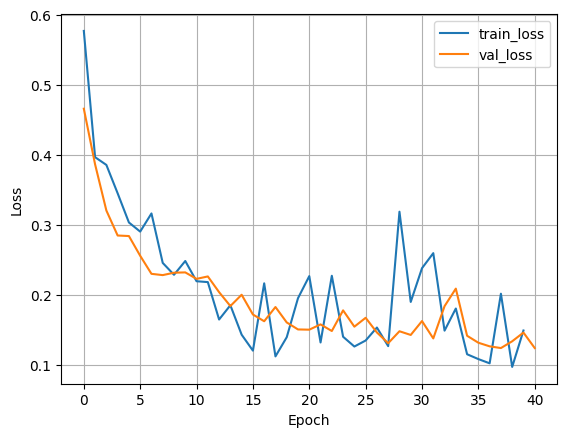

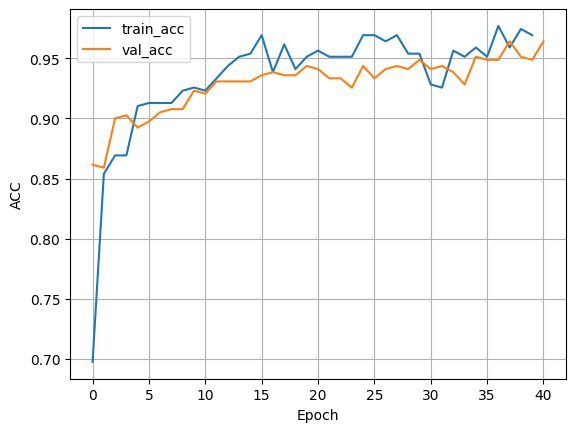

In [28]:
metrics = pd.read_csv(f"logs\\{best_trial.number}\\my-model\\version_0\\metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "val_loss"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="Loss"
)
df_metrics[["train_acc", "val_acc"]].plot(
    grid=True, legend=True, xlabel="Epoch", ylabel="ACC"
)

plt.show()

- Model Generalization: The model appears to have learned the underlying patterns in the data without overfitting. This is a positive sign, as it suggests that the model will likely perform well on unseen data (e.g., test data).
- Stable Learning: Both loss and accuracy curves for training and validation are behaving consistently, implying that the learning process is stable and the model is not overfitting or underfitting.

#### Predict and save images with defects

In [29]:
trainer = L.Trainer(accelerator="gpu" if torch.cuda.is_available() else "cpu")

start_time = time.time()
trainer.test(lightning_model, datamodule=dm)
end_time = time.time()

image_count = len(dm.test_dataset)
duration = end_time - start_time
duration_per_image = duration / image_count
print(f"Prediction time: {duration:.2f} seconds")
print(f"Prediction time per image: {duration_per_image:.2f} seconds")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 9/9 [00:15<00:00,  0.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9576923251152039
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Prediction time: 18.60 seconds
Prediction time per image: 0.04 seconds


- Performance: The model's test accuracy is high, and the fast prediction times per image indicate both strong predictive power and efficient execution. The model is suitable for deployment in applications where both accuracy and speed are important.
- Model Efficiency: The fast prediction time suggests the model can scale well to larger datasets or be used in real-time prediction scenarios.

#### Classification Report

In [30]:
all_preds = []
all_labels = []

accuracy_metric = torchmetrics.Accuracy(task="binary", num_classes=2)
lightning_model.eval()
with torch.inference_mode():
    for batch in dm.test_dataloader():
        inputs, labels, _ = batch
        outputs = lightning_model(inputs)
        preds = (outputs > 0.5).long().squeeze()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds_tensor = torch.tensor(all_preds)
all_labels_tensor = torch.tensor(all_labels)

In [31]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       207
           1       0.97      0.96      0.96       313

    accuracy                           0.96       520
   macro avg       0.95      0.96      0.96       520
weighted avg       0.96      0.96      0.96       520



- The model performs very well with high precision, recall, and F1-scores, particularly for both defective and non-defective classes.
- Class 1 (Non-defective) is slightly favored, which is typical if the data is imbalanced, but the performance remains balanced across both classes.
- The high accuracy and strong F1-scores indicate the model's suitability for deployment in defect detection tasks.

#### Confusion Matrix

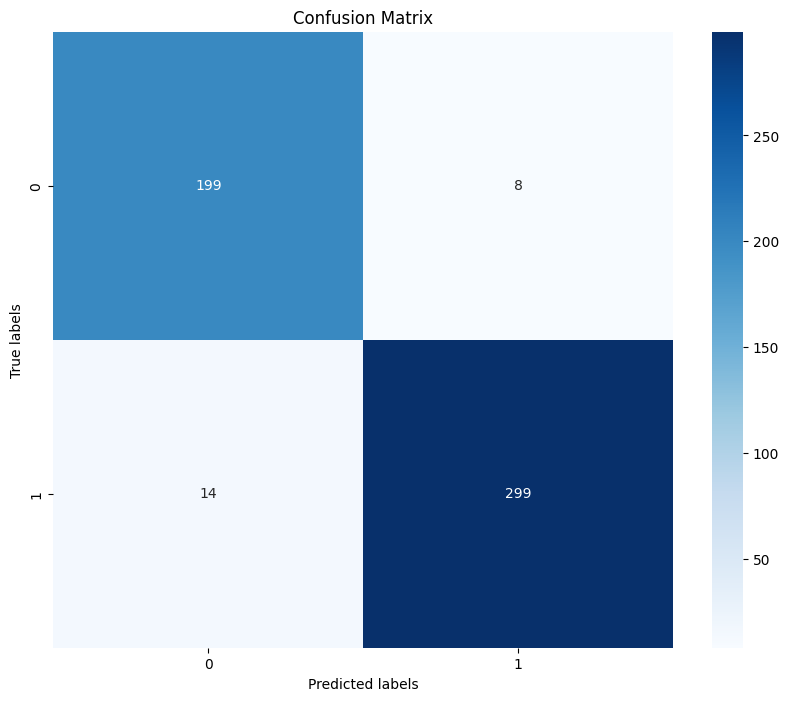

In [32]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=np.arange(2),
    yticklabels=np.arange(2),
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

<a id="defects"></a>
## 5.4. Defects

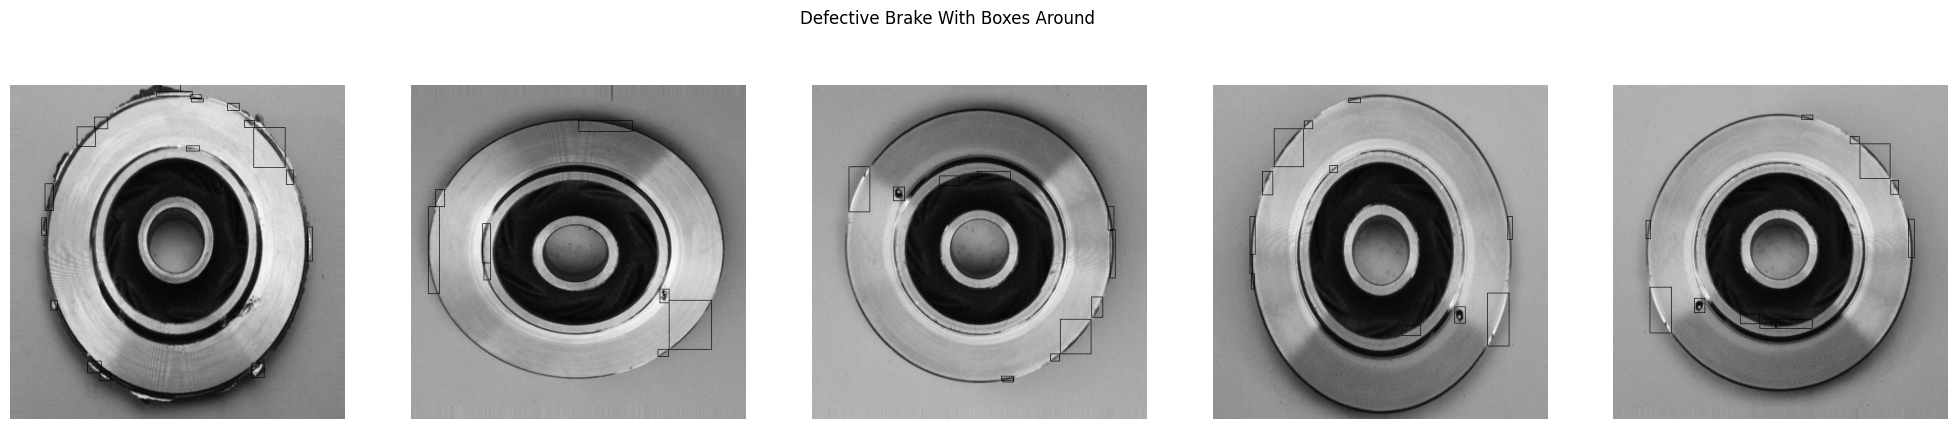

In [33]:
predicted_dir = os.path.join(data_dir, "pred_def")
predicted_images = [
    os.path.join(predicted_dir, img) for img in os.listdir(predicted_dir)
]
show_images(predicted_images[:5], "Defective Brake With Boxes Around")

- While the model's overall performance is strong, it sometimes overestimates the presence of defects, marking areas where there are none. Addressing this could involve tweaking the defect criteria, adjusting model thresholds, or refining the dataset to minimize noise and better balance the model's sensitivity and specificity.

<a id="conclusion"></a>
# 6. Conclusion

### 1. Model Performance
- The model achieved a test accuracy of approximately 96%, demonstrating strong classification performance on the brake disc dataset.
- The train and validation loss curves are closely aligned, indicating that the model is not overfitting.
- Similarly, the train and validation accuracy are also close, suggesting that the model generalizes well to unseen data.
- The performance of the model on the test set and its consistency across different splits of the data are promising, with a minimal gap between train/validation metrics.

### 2. Hyperparameter Optimization Insights
- The best-performing hyperparameters found through Optuna were:
  - Optimizer: AdamW
  - Activation Function: LeakyReLU
  - Learning Rate: 0.00131
  - Weight Decay: 0.01156
  - Dropout Ratio: 0.329
  - Hidden Layers: (512, 256)
- The model benefited from the AdamW optimizer and LeakyReLU activation, which provided stability during training.
- The choice of hidden layers (512 and 256 neurons) and the dropout ratio helped the model balance complexity and regularization.

### 3. Feature Engineering Insights
- The Sobel filter was applied to detect edges in the images. This showed that defective brake discs exhibit irregular, sharp-edged shapes, while normal (OK) discs maintain a more circular structure.
- The frequency distribution of pixel intensities revealed that OK discs typically show higher frequencies in the 0.7 to 0.9 intensity range, indicating a more consistent and less noisy texture compared to defective discs.
- A variety of features were extracted from the images, contributing to the model's ability to distinguish between defective and non-defective discs.

### 4. Areas for Improvement
- Defect Detection Precision: While the model performs well, it sometimes marks areas without defects. Refining the defect criteria or adjusting the confidence threshold for defect detection could help reduce false positives.
- Data Augmentation: To further enhance the model's ability to generalize, introducing additional data augmentation techniques may help it learn from more varied and challenging examples.
- Model Complexity: Experimenting with deeper or more specialized architectures (e.g., convolutional neural networks) could further improve performance, particularly in detecting complex defect patterns.

### 5. Final Thoughts
This project successfully implemented a deep learning pipeline to classify defective and non-defective brake discs. By applying feature extraction techniques (e.g., Sobel filter) and optimizing the model using Optuna, the resulting model achieved strong performance. However, there are opportunities to improve precision in defect detection and refine the model further, particularly through additional data processing, architectural exploration, and fine-tuning.
